# Phase 4 Project

## Time Series Model

Let us start by loading the datasets and see what type of data we are dealing with

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import skew

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

from colorama import Fore
from colorama import Style

plt.style.use('ggplot')

Let's load US energy generation

In [2]:
df = pd.read_csv('organised_Gen.csv',
                 parse_dates={ 'date': ['YEAR', 'MONTH'] })
df

date  Unnamed: 0 STATE                         TYPE OF PRODUCER  \
0      2001-01-01           0    AK            Total Electric Power Industry   
1      2001-01-01           1    AK            Total Electric Power Industry   
2      2001-01-01           2    AK            Total Electric Power Industry   
3      2001-01-01           3    AK            Total Electric Power Industry   
4      2001-01-01           4    AK            Total Electric Power Industry   
...           ...         ...   ...                                      ...   
496769 2022-05-01       10581    WY  Electric Generators, Electric Utilities   
496770 2022-05-01       10582    WY  Electric Generators, Electric Utilities   
496771 2022-05-01       10583    WY  Electric Generators, Electric Utilities   
496772 2022-05-01       10584    WY  Electric Generators, Electric Utilities   
496773 2022-05-01       10585    WY  Electric Generators, Electric Utilities   

                     ENERGY SOURCE  GENERATION (Megawatthours)  
0                             Coal                     46903.0  
1                        Petroleum                     71085.0  
2                      Natural Gas                    367521.0  
3       Hydroelectric Conventional                    104549.0  
4                             Wind                        87.0  
...                            ...                         ...  
496769                        Coal                   2071403.0  
496770  Hydroelectric Conventional                     96790.0  
496771                 Natural Gas                     91570.0  
496772                   Petroleum                      1812.0  
496773                        Wind                    452913.0  

[496774 rows x 6 columns]

## Data Preparation:

In [3]:
df.set_index('date', inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df

STATE                         TYPE OF PRODUCER  \
date                                                        
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
2001-01-01    AK            Total Electric Power Industry   
...          ...                                      ...   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   
2022-05-01    WY  Electric Generators, Electric Utilities   

                         ENERGY SOURCE  GENERATION (Megawatthours)  
date                                                                
2001-01-01                        Coal                     46903.0  
2001-01-01                   Petroleum                     71085.0  
2001-01-01                 Natural Gas                    367521.0  
2001-01-01  Hydroelectric Conventional                    104549.0  
2001-01-01                        Wind                        87.0  
...                                ...                         ...  
2022-05-01                        Coal                   2071403.0  
2022-05-01  Hydroelectric Conventional                     96790.0  
2022-05-01                 Natural Gas                     91570.0  
2022-05-01                   Petroleum                      1812.0  
2022-05-01                        Wind                    452913.0  

[496774 rows x 4 columns]

In [4]:
df.isna().sum()

STATE                         0
TYPE OF PRODUCER              0
ENERGY SOURCE                 0
GENERATION (Megawatthours)    0
dtype: int64

In [5]:
df.describe()

GENERATION (Megawatthours)
count                4.967740e+05
mean                 1.393384e+06
std                  1.078685e+07
min                 -9.978550e+05
25%                  1.643000e+03
50%                  2.330103e+04
75%                  2.792042e+05
max                  4.217967e+08

Very interesting! Could pick a couple of energy sources and analyze them in parallel

In [6]:
df['ENERGY SOURCE'].value_counts()

Total                             73356
Natural Gas                       66684
Petroleum                         63176
Coal                              47642
Other Biomass                     46148
Hydroelectric Conventional        38842
Other                             36241
Wood and Wood Derived Fuels       30524
Wind                              25421
Solar Thermal and Photovoltaic    19393
Other Gases                       18212
Nuclear                           16754
Pumped Storage                    10139
Geothermal                         4242
Name: ENERGY SOURCE, dtype: int64

In [7]:
df['TYPE OF PRODUCER'].value_counts()

Total Electric Power Industry                       134452
Electric Generators, Electric Utilities              93792
Electric Generators, Independent Power Producers     89439
Combined Heat and Power, Industrial Power            77804
Combined Heat and Power, Commercial Power            53928
Combined Heat and Power, Electric Power              47359
Name: TYPE OF PRODUCER, dtype: int64

In [8]:
US_total=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']
US_total=US_total.loc[US_total['STATE']=='US-TOTAL']

In [9]:
US_total

STATE               TYPE OF PRODUCER  \
date                                                  
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
...              ...                            ...   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   

                             ENERGY SOURCE  GENERATION (Megawatthours)  
date                                                                    
2001-01-01                            Coal                 177287111.0  
2001-01-01                       Petroleum                  18111843.0  
2001-01-01                     Natural Gas                  42388663.0  
2001-01-01                     Other Gases                    718442.0  
2001-01-01                         Nuclear                  68707077.0  
...                                    ...                         ...  
2022-05-01                       Petroleum                   1524488.0  
2022-05-01  Solar Thermal and Photovoltaic                  15151118.0  
2022-05-01                   Other Biomass                   1440366.0  
2022-05-01                            Wind                  41891907.0  
2022-05-01     Wood and Wood Derived Fuels                   3073482.0  

[3598 rows x 4 columns]

In [10]:
US_total['ENERGY SOURCE'].value_counts()

Other Gases                       257
Nuclear                           257
Hydroelectric Conventional        257
Solar Thermal and Photovoltaic    257
Pumped Storage                    257
Petroleum                         257
Wind                              257
Coal                              257
Natural Gas                       257
Total                             257
Other Biomass                     257
Geothermal                        257
Wood and Wood Derived Fuels       257
Other                             257
Name: ENERGY SOURCE, dtype: int64

#### Changing Scale
GIven the high values for the column 'Generation (Megawatthours)' once we take the totals, we will convert the units to Terawatts per hour, where TWh=MWh*10^6.

In [11]:
US_total["Generation (TWh)"]=US_total["GENERATION (Megawatthours)"]/1000000
US_total.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)
US_total

STATE               TYPE OF PRODUCER  \
date                                                  
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
2001-01-01  US-TOTAL  Total Electric Power Industry   
...              ...                            ...   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   
2022-05-01  US-TOTAL  Total Electric Power Industry   

                             ENERGY SOURCE  Generation (TWh)  
date                                                          
2001-01-01                            Coal        177.287111  
2001-01-01                       Petroleum         18.111843  
2001-01-01                     Natural Gas         42.388663  
2001-01-01                     Other Gases          0.718442  
2001-01-01                         Nuclear         68.707077  
...                                    ...               ...  
2022-05-01                       Petroleum          1.524488  
2022-05-01  Solar Thermal and Photovoltaic         15.151118  
2022-05-01                   Other Biomass          1.440366  
2022-05-01                            Wind         41.891907  
2022-05-01     Wood and Wood Derived Fuels          3.073482  

[3598 rows x 4 columns]

In [12]:
US_source=US_total.groupby(by=[US_total.index,"ENERGY SOURCE"]).sum().reset_index()

In [13]:
US_source=US_source[(US_source['ENERGY SOURCE']!='Total')]

### Previewing the data by energy source

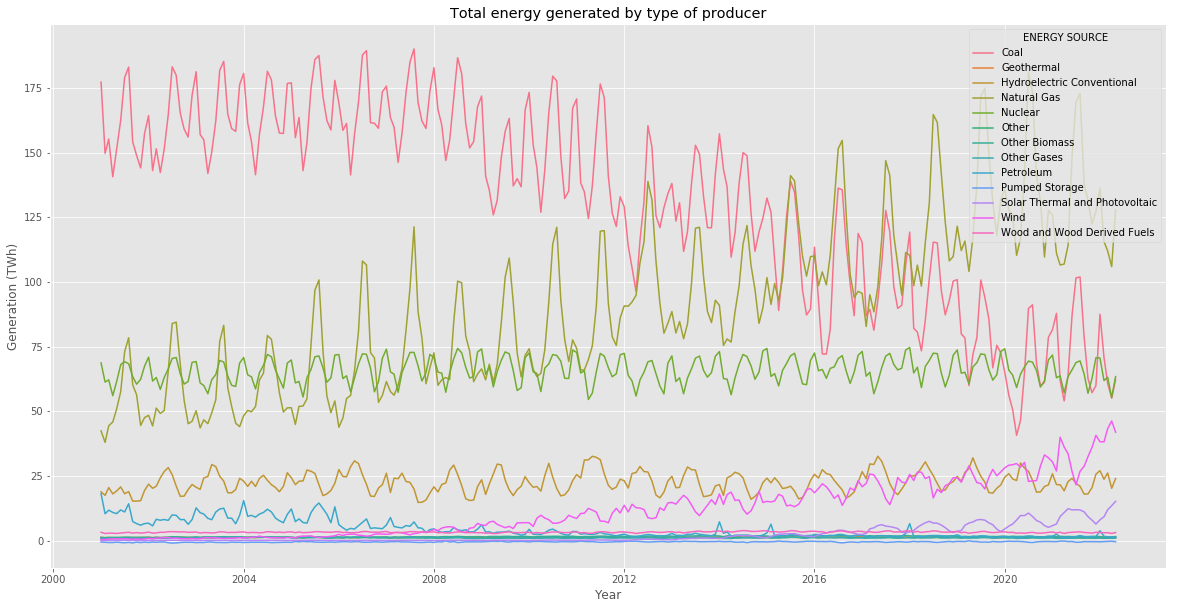

In [14]:
plt.figure(figsize=(20,10))
#Seaborn style
sns.color_palette("tab10")
#Plot - using mdates for correct datetime format
sns.lineplot(data=US_source, x=US_source['date'] ,y=US_source['Generation (TWh)'],hue="ENERGY SOURCE")
#Plot additional properties
#plt.grid()
#plt.xticks([str(i+2001)+"-01-01" for i in range(22)])
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()


Let us divide up the energy sources to be able to better see form the graphs their trends.

In [15]:
top_3 = ['Coal' ,'Natural Gas', 'Nuclear'] 
US_top3=US_source[US_source['ENERGY SOURCE'].isin(top_3)]

In [16]:
US_top3

date ENERGY SOURCE  Generation (TWh)
0    2001-01-01          Coal        177.287111
3    2001-01-01   Natural Gas         42.388663
4    2001-01-01       Nuclear         68.707077
14   2001-02-01          Coal        149.735484
17   2001-02-01   Natural Gas         37.966927
...         ...           ...               ...
3573 2022-04-01   Natural Gas        105.934050
3574 2022-04-01       Nuclear         55.289540
3584 2022-05-01          Coal         62.288238
3587 2022-05-01   Natural Gas        127.926186
3588 2022-05-01       Nuclear         63.381624

[771 rows x 3 columns]

### Top 3: Coal, Natural Gas and  Nuclear

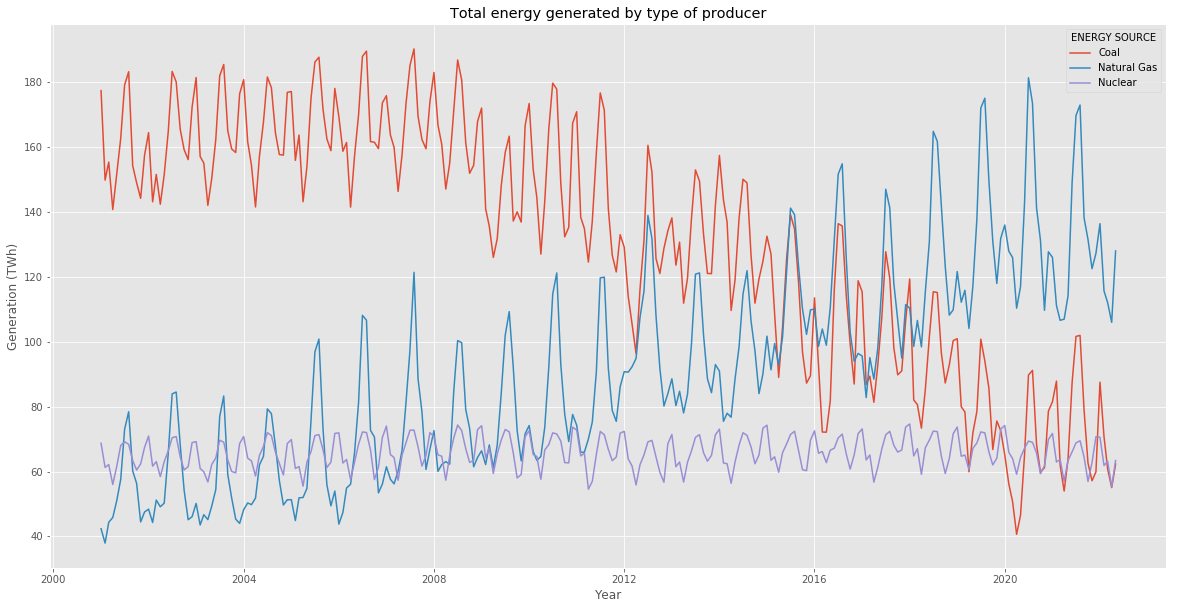

In [17]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_top3, x=US_top3['date'] ,y=US_top3['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()


### Next 4: Wind, Hydroelectric, Solar and Oil

In [18]:
snd_4 = ['Wind' ,'Hydroelectric Conventional', 'Solar Thermal and Photovoltaic', 'Petroleum'] 
US_snd4=US_source[US_source['ENERGY SOURCE'].isin(snd_4)]

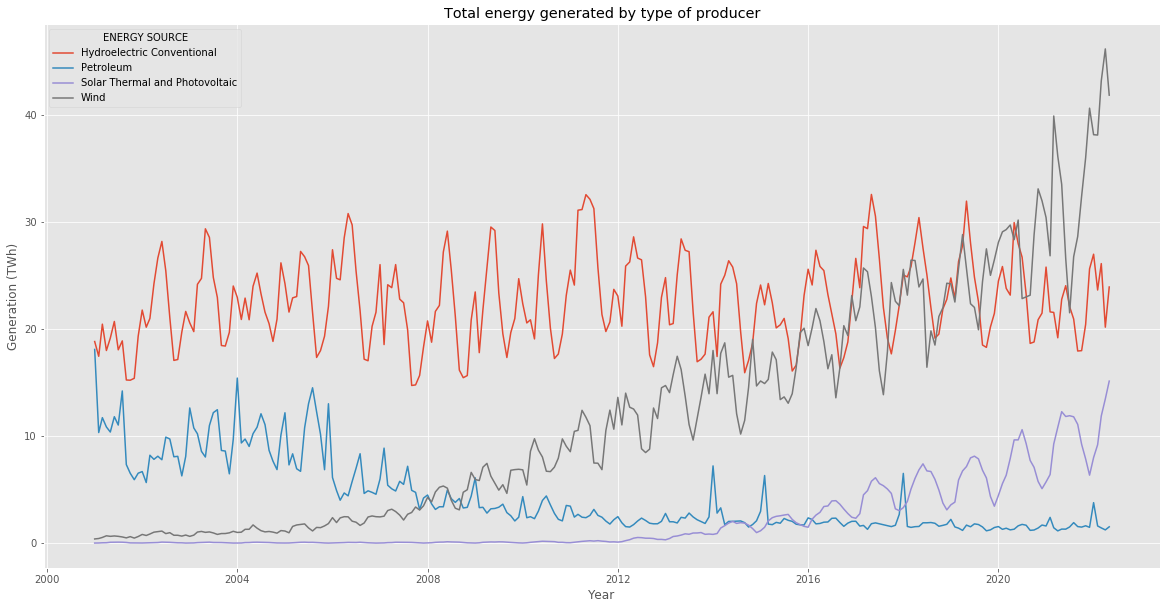

In [19]:
plt.figure(figsize=(20,10))
sns.color_palette("viridis")
sns.lineplot(data=US_snd4, x=US_snd4['date'] ,y=US_snd4['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()

### Bottom of the pack:

In [20]:
bottom=['Other','Other Gases','Pumped Storage','Wood and Wood Derived Fuels'\
        ,'Other Biomass','Geothermal']
US_bot=US_source[US_source['ENERGY SOURCE'].isin(bottom)]

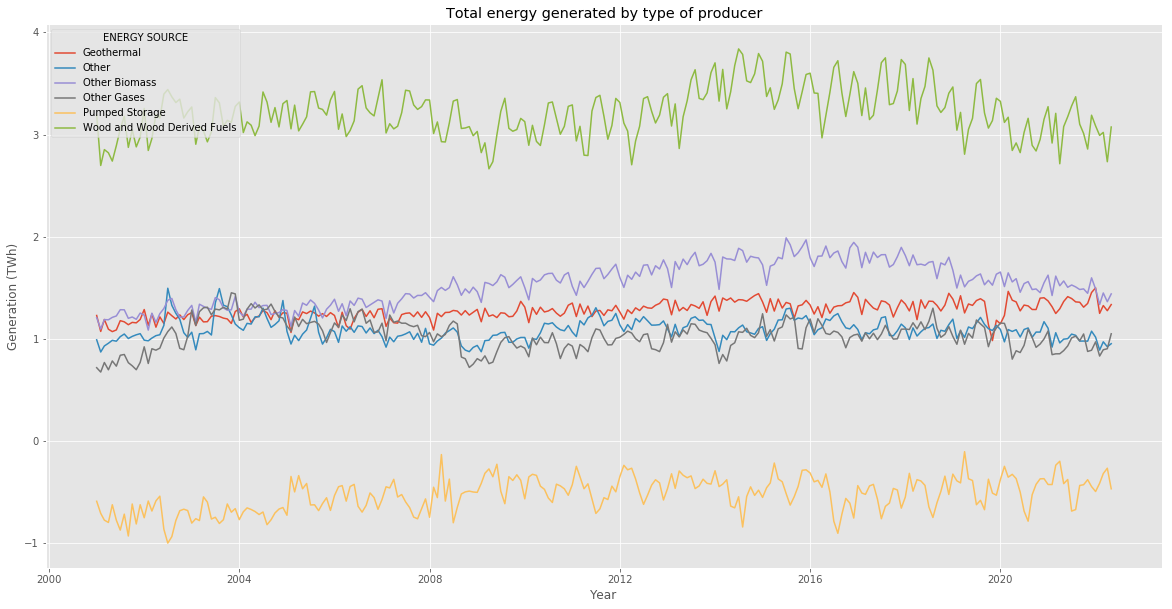

In [21]:
plt.figure(figsize=(20,10))
sns.color_palette("tab10")
sns.lineplot(data=US_bot, x=US_bot['date'] ,y=US_bot['Generation (TWh)'],hue="ENERGY SOURCE")
plt.title("Total energy generated by type of producer")
plt.xlabel("Year");
plt.show()

### The three most growing ones: Natural Gas, Solar and Wind

The trends that have shown to be more interesting, with an upward trend over time are:
 Natural Gas, Wind and Solar. So let us preview those.

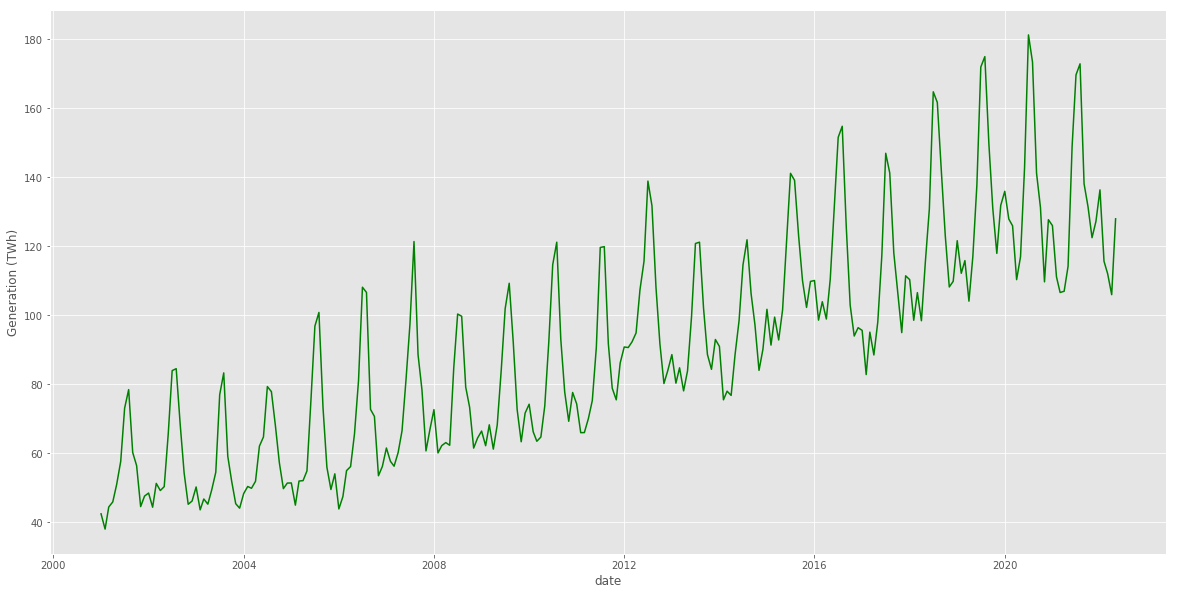

In [22]:
plt.figure(figsize=(20,10))
US_nat=US_total.loc[US_total['ENERGY SOURCE']=='Natural Gas']
sns.lineplot(x=US_nat.index, y=US_nat['Generation (TWh)'], color='green');

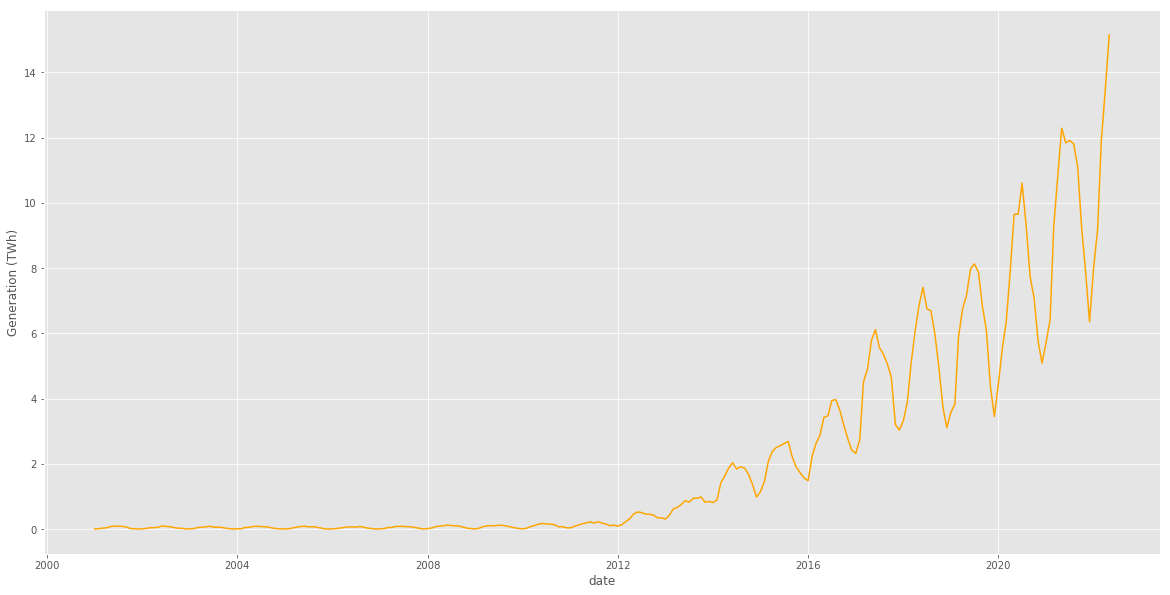

In [23]:
plt.figure(figsize=(20,10))
US_sol=US_total.loc[US_total['ENERGY SOURCE']=='Solar Thermal and Photovoltaic']
sns.lineplot(x=US_sol.index, y=US_sol['Generation (TWh)'], color='orange');

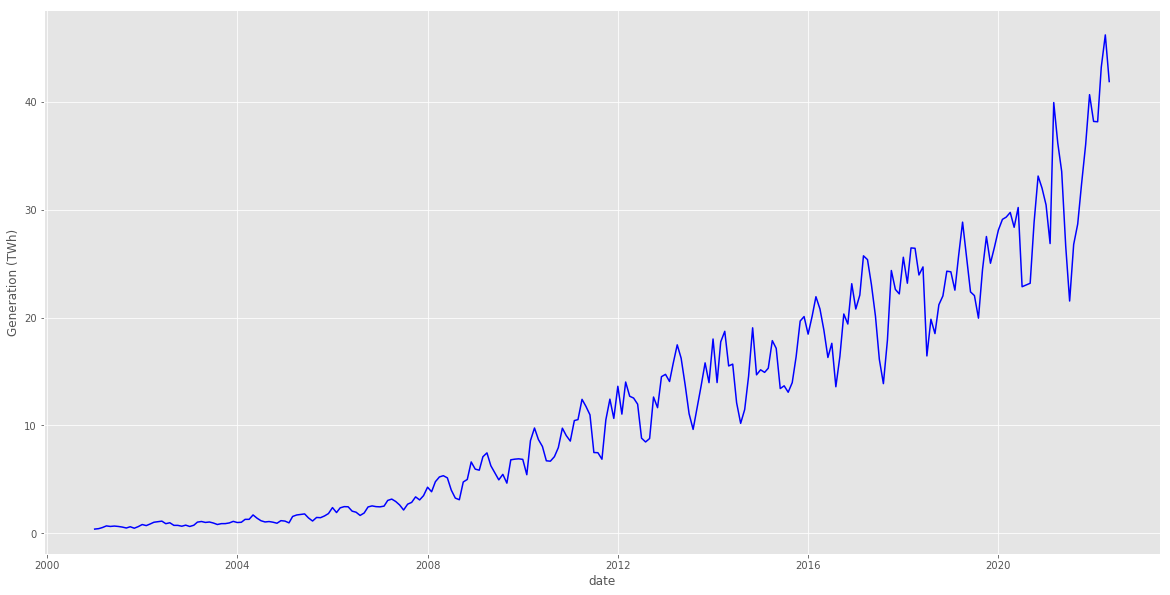

In [24]:
plt.figure(figsize=(20,10))
US_wind=US_total.loc[US_total['ENERGY SOURCE']=='Wind']
sns.lineplot(x=US_wind.index,y=US_wind['Generation (TWh)'], color='blue');

## Checking for Normality, skewness and kurtosis

#### Natural Gas:

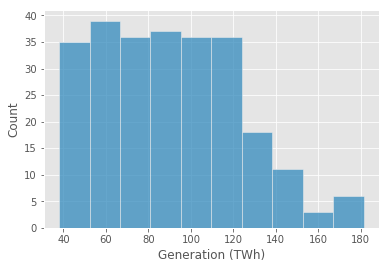

In [25]:
sns.histplot(US_nat['Generation (TWh)']);

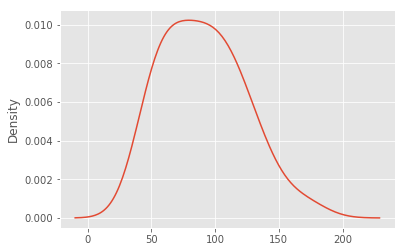

In [26]:
sns.kdeplot(np.array(US_nat['Generation (TWh)']), bw=0.5);

There is clearly a skew in the data because the lowest value of production we have, around 2001, is around 40 TWh, it does not start at zero. Let us use our tools from SciPy to get actual values for normality, skewness and kurtosis.

In [27]:
k2, p = stats.normaltest(US_nat['Generation (TWh)'])
kur = kurtosis(US_nat['Generation (TWh)'], fisher=True)
sk=skew(US_nat['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:0.003959050613625347
The value for kurtosis for this sample is: -0.35228324109119846
The value of skewness for this sample is:0.4830844892501781


The null hypothesis for the normal test is that the sample comes from a normal distribution.
<br>In our case with a standard alpha of 0.05 we can say that we can reject the null hypothesis and say that our sample is not normally distributed.
<br>With Fisher's definition of kurtosis normal=0 so we are pretty close to normality in terms of kurtosis.
<br>The value of 0.48 for skew indicates that our distribution is moderately skewed, as we could infer from looking at the graphs.

#### Solar

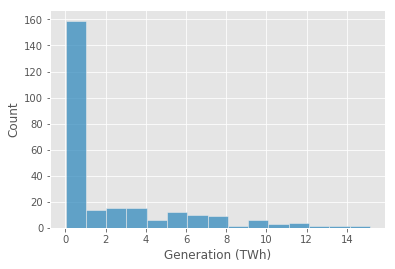

In [28]:
sns.histplot(US_sol['Generation (TWh)']);

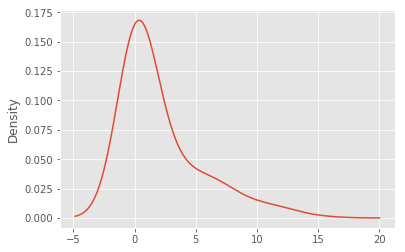

In [29]:
sns.kdeplot(np.array(US_sol['Generation (TWh)']), bw=0.5);

In [30]:
k2, p = stats.normaltest(US_sol['Generation (TWh)'])
kur = kurtosis(US_sol['Generation (TWh)'], fisher=True)
sk=skew(US_sol['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:6.333758801915125e-19
The value for kurtosis for this sample is: 2.135719804718372
The value of skewness for this sample is:1.6823253826109177


In the case of solar energy also we can reject the null hypothesis and say that our sample is not normally distributed.
<br>This sample shows a kurtosis higher than 2, which also takes our sample outside of normality.
<br>The value of 1.68 for skew indicates that our distribution is skewed, but still acceptable in the range for normality.

#### Wind

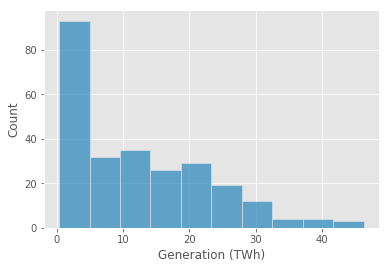

In [31]:
sns.histplot(US_wind['Generation (TWh)']);

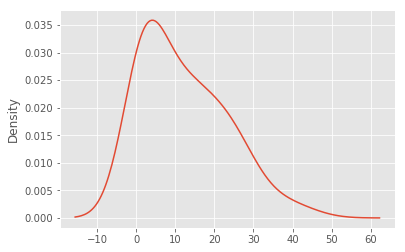

In [32]:
sns.kdeplot(np.array(US_wind['Generation (TWh)']), bw=0.5);

In [33]:
k2, p = stats.normaltest(US_wind['Generation (TWh)'])
kur = kurtosis(US_wind['Generation (TWh)'], fisher=True)
sk=skew(US_wind['Generation (TWh)'])
print(f"The p for the normality test for this sample is:{p}\nThe value for kurtosis for this sample is: {kur}\nThe value of skewness for this sample is:{sk}")

The p for the normality test for this sample is:1.2775838040979476e-05
The value for kurtosis for this sample is: -0.14672678485081514
The value of skewness for this sample is:0.7875242470552442


For our sample of energy generated by wind we can reject the null hypothesis and say that our sample is not normally distributed.
<br>This sample shows a kurtosis of -0.14 which means the curve is too flat to be normal, but still pretty close to the zero of normality.
<br>The value of 0.78 for skew indicates that our distribution is skewed, but not very far from the range for normality.

The ultimately deciding factor is the p value so we have to accept that all three of our samples are not normally distributed. <br>Given time series this is not a requirement for our data, but this study let us understand more the characteristic of the samples we working with.

## Split Train Validation and Test set

Now that we have decided what sources we are going to work on, we are going to perform a train-validation-test split so that the models we are going to create, based only on the information we have from the train, do not suffer from data-leaking.
We will consequently test our models on the validation set, to choose the best performing model, and we will utimately test it on the test set, that in this way will represent datat that was not unseen for the model.
We will use this comparison with the test to get a sense of our margins of error, and then use our model to forecast for the next 3 years.

In [34]:
nat=US_nat['Generation (TWh)']
sol=US_sol['Generation (TWh)']
wind=US_wind['Generation (TWh)']

In [35]:
# Definig the 80% cutoff for the split train - validation&test
cutoff = round(nat.shape[0]*0.8)
cutoff

206

In [36]:
# Defining the two sets, train and test& validation based on the cutoff
train = nat[:(cutoff+1)] #the +1 is added to avoid gaps in the series

#testval = nat[cutoff:]
test=nat[cutoff:]

In [37]:
#testval.index[0]
test.index[0]

Timestamp('2018-03-01 00:00:00')

In [38]:
test.index[-1]

Timestamp('2022-05-01 00:00:00')

From here we can see that having performed an 80/20 split for train and test we have the year from January 2018 on as part of the test.

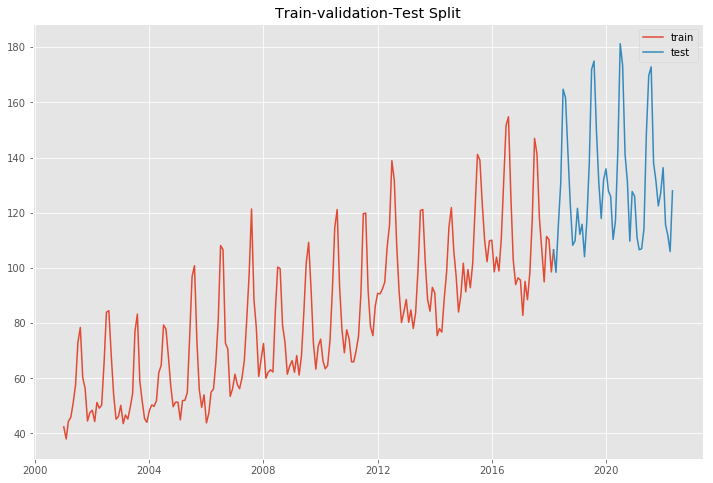

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
#ax.plot(val, label='validation')
ax.plot(test, label='test')
ax.set_title('Train-validation-Test Split');
plt.legend();

In [40]:
train

date
2001-01-01     42.388663
2001-02-01     37.966927
2001-03-01     44.364414
2001-04-01     45.842746
2001-05-01     50.934205
                 ...    
2017-11-01     94.928341
2017-12-01    111.397792
2018-01-01    110.292909
2018-02-01     98.511852
2018-03-01    106.523780
Name: Generation (TWh), Length: 207, dtype: float64

In [41]:
test

date
2018-03-01    106.523780
2018-04-01     98.371080
2018-05-01    115.283982
2018-06-01    130.826400
2018-07-01    164.749060
2018-08-01    161.676241
2018-09-01    141.785528
2018-10-01    123.142239
2018-11-01    108.167635
2018-12-01    109.801976
2019-01-01    121.581777
2019-02-01    112.135473
2019-03-01    115.806072
2019-04-01    104.053161
2019-05-01    117.052615
2019-06-01    137.827808
2019-07-01    171.941961
2019-08-01    174.955372
2019-09-01    149.687661
2019-10-01    130.940660
2019-11-01    117.903947
2019-12-01    131.830286
2020-01-01    135.905175
2020-02-01    127.861217
2020-03-01    125.895408
2020-04-01    110.291535
2020-05-01    116.933505
2020-06-01    142.822497
2020-07-01    181.248097
2020-08-01    173.379404
2020-09-01    141.155144
2020-10-01    131.232950
2020-11-01    109.650802
2020-12-01    127.674265
2021-01-01    125.959747
2021-02-01    111.110664
2021-03-01    106.565144
2021-04-01    106.920249
2021-05-01    114.131496
2021-06-01    148.84

### Validation Set

Instead of taking only one validation set as part of the test set, we chose to use the `TimeSeriesSpit()` function to create splits of train and validation, that can be used for a cross validation.
<br>We can see from the indeces below that the default number of splits is 5, and that the validation set always comes right after the train set, but the train set is increasing in size with every split.
<br>The size of the validation set remains the same.
<br>We will use this later to do cross validation on our models.

In [42]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 70]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70] [ 71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104

### Subtracting Rolling Mean

In [43]:
roll_mean = train.rolling(window=12, center=False).mean()
roll_std = train.rolling(window=12, center=False).std()

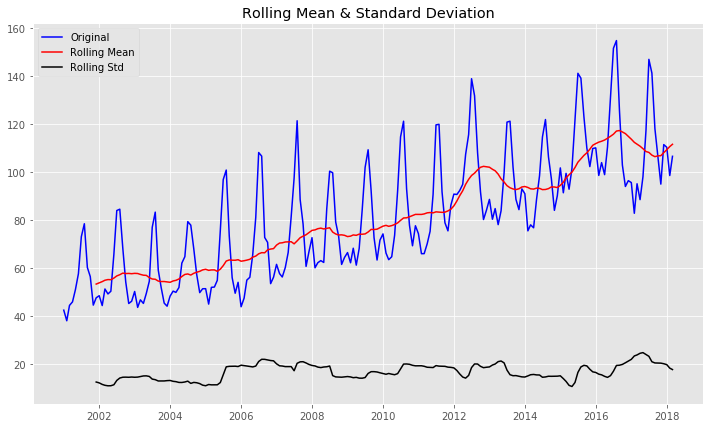

In [44]:
fig = plt.figure(figsize=(12,7))
plt.plot(train, color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [45]:
dftest = adfuller(train)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)

(-0.4857072897184561, 0.8947755741324734, 15, 191, {'1%': -3.465058702600837, '5%': -2.8767942675230356, '10%': -2.5749014492475535}, 1250.5326958945707)


In [46]:
print ('Results of Dickey-Fuller test: \n')

print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -0.485707
p-value                          0.894776
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


The p values is clearly > 0.05, the series is not stationary as we could expect.

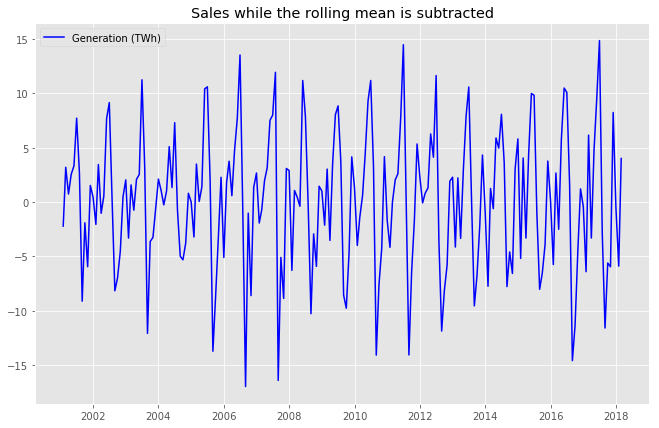

In [47]:
roll_mean_nat = train.rolling(window=2, center=False).mean()
# Subtract the moving average from the original data
data_mrm_nat = train - roll_mean_nat
# Drop the missing values from time series calculated above
data_mrm_nat.dropna(inplace=True)
# Plot sales with rolling mean subtracted
fig = plt.figure(figsize=(11,7))
plt.plot(data_mrm_nat, color='blue')#,label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show();#(block=False)

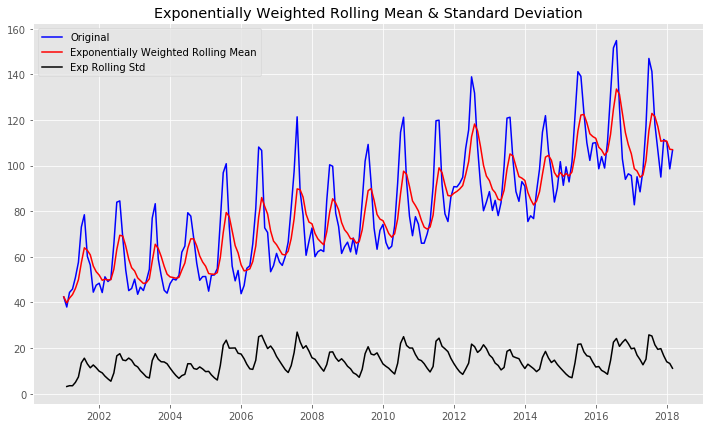

In [48]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = train.ewm(halflife=2).mean()
roll_std = train.ewm(halflife=2).std()
# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(train, color='blue',label='Original')
mean = plt.plot(exp_roll_mean, color='red', label='Exponentially Weighted Rolling Mean')
plt.plot(roll_std, color='black', label = 'Exp Rolling Std')
plt.legend(loc='best')
plt.title('Exponentially Weighted Rolling Mean & Standard Deviation')
plt.show(block=False)

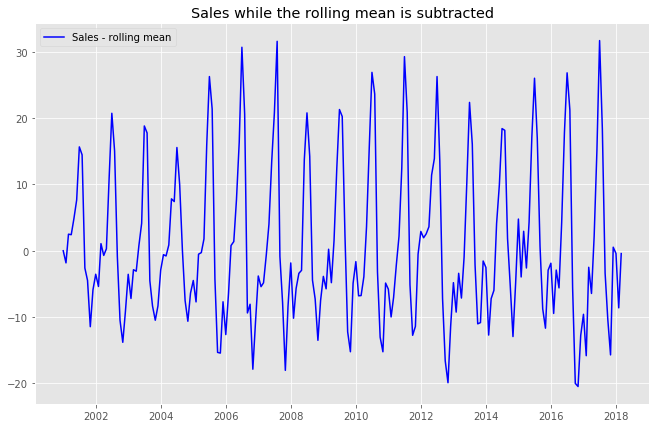

In [49]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = train - exp_roll_mean
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_exp_roll_mean, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Sales while the rolling mean is subtracted')
plt.show(block=False)

In [50]:
dftest = adfuller(data_mrm_nat)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.202030
p-value                          0.000654
#Lags Used                      15.000000
Number of Observations Used    190.000000
Critical Value (1%)             -3.465244
Critical Value (5%)             -2.876875
Critical Value (10%)            -2.574945
dtype: float64


In [51]:
dftest = adfuller(data_minus_exp_roll_mean)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.697668
p-value                          0.000085
#Lags Used                      14.000000
Number of Observations Used    192.000000
Critical Value (1%)             -3.464875
Critical Value (5%)             -2.876714
Critical Value (10%)            -2.574859
dtype: float64


> Here maybe a paragraph in which you explain what it means, the fact that the residualas are stationary and why do we subract the rolling mean, because there is a dependence on the previous periods, specifically the amounts of periods specified in the window. And that expotential means the ones closer in time are more relevant then the others.

## Series Decomposition

**When log is better than natural, is because the trend is exponential (growth in our case) inste of linear growth.**

### Decomposing Natural Gas

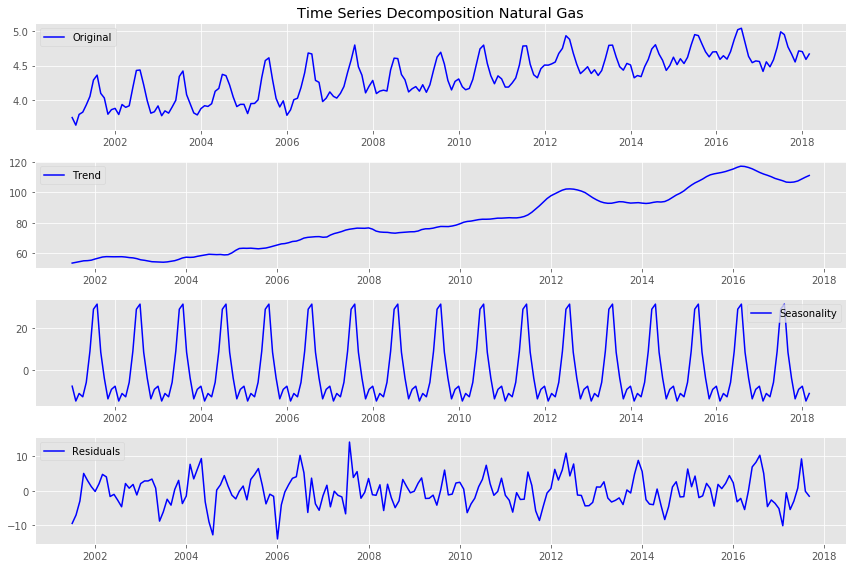

In [52]:
decomposition = seasonal_decompose(train)

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

In [53]:
residual.dropna(inplace=True)

In [54]:
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -6.072536e+00
p-value                        1.141737e-07
#Lags Used                     1.500000e+01
Number of Observations Used    1.790000e+02
Critical Value (1%)           -3.467420e+00
Critical Value (5%)           -2.877826e+00
Critical Value (10%)          -2.575452e+00
dtype: float64


### Decomposing log(natural gas)

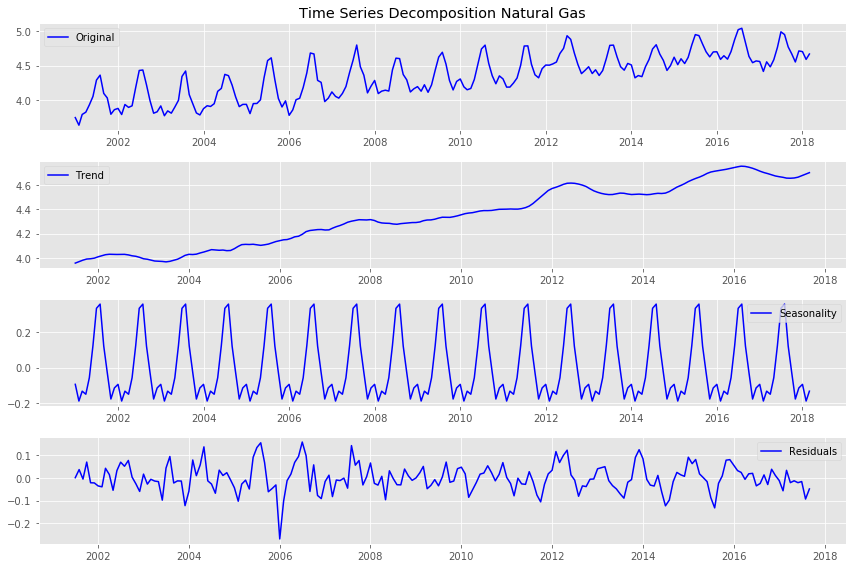

In [55]:
decomposition = seasonal_decompose(np.log(train))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

In [56]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                -8.280252e+00
p-value                        4.540005e-13
#Lags Used                     8.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


## Multiplicative instead of additive models

Not getting better. Let's try multiplicative instead of additive. Back to the whole series, which performed better.

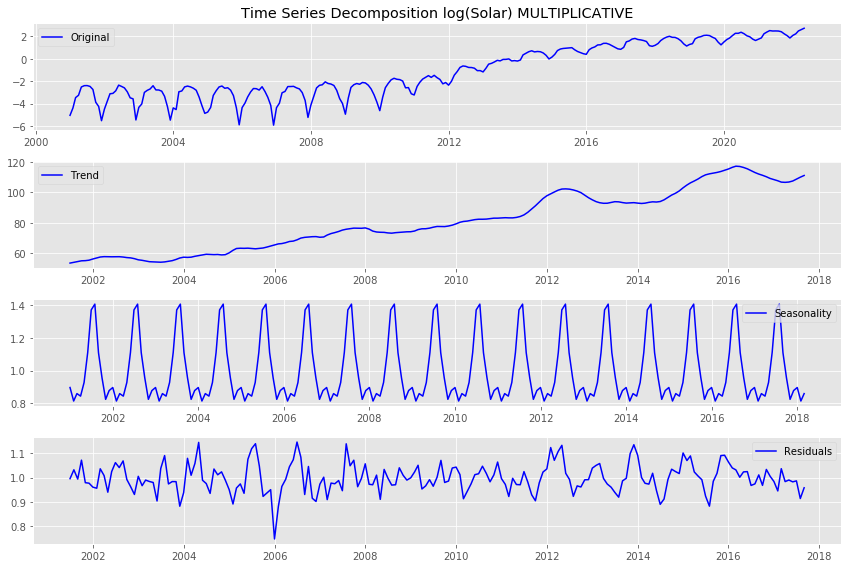

In [57]:
decomposition = seasonal_decompose(train, model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition log(Solar) MULTIPLICATIVE')
plt.plot(np.log(sol), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [58]:
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -5.519263
p-value                          0.000002
#Lags Used                       9.000000
Number of Observations Used    185.000000
Critical Value (1%)             -3.466201
Critical Value (5%)             -2.877293
Critical Value (10%)            -2.575168
dtype: float64


Much better!
Now out of curiosity let me try to do multiplicative for the other resources too and see if the residulas improve.

### Multiplicative log

Results of Dickey-Fuller test: 

Test Statistic                -8.808333e+00
p-value                        2.023057e-14
#Lags Used                     8.000000e+00
Number of Observations Used    1.860000e+02
Critical Value (1%)           -3.466005e+00
Critical Value (5%)           -2.877208e+00
Critical Value (10%)          -2.575122e+00
dtype: float64


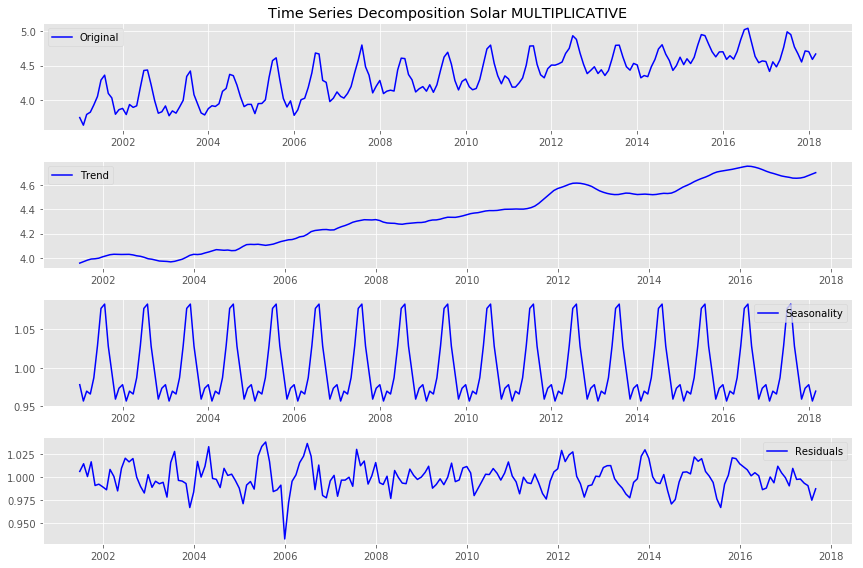

In [59]:
decomposition = seasonal_decompose(np.log(train), model='multiplicative')

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Solar MULTIPLICATIVE')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()
residual.dropna(inplace=True)
dftest = adfuller(residual)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

## Studying Autocorrelation

> maybe will cut this

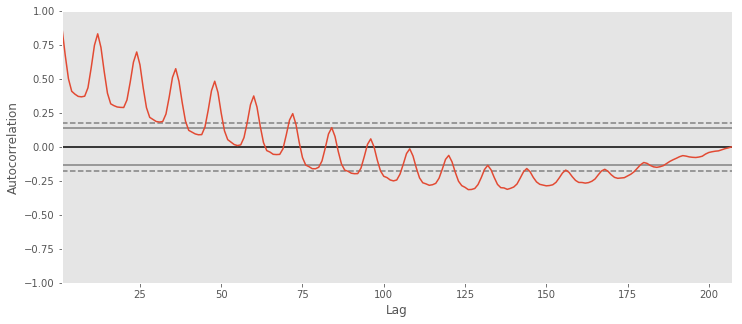

In [60]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(train);

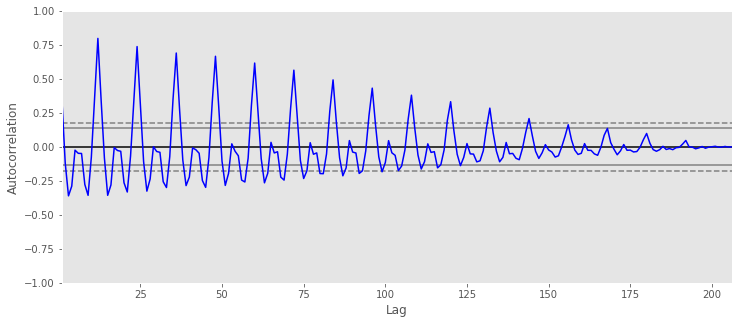

In [61]:
nat_diff = train.diff(periods=1)
nat_diff.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(nat_diff, color='b');

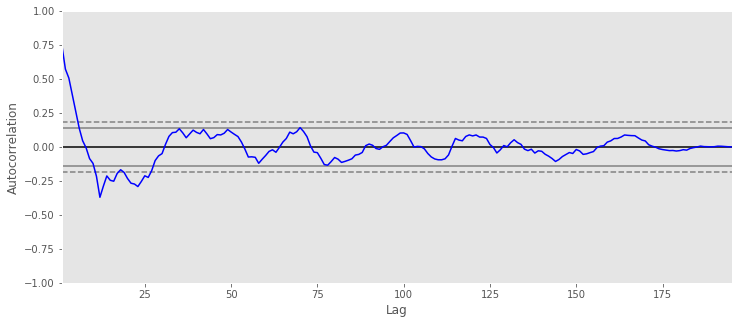

In [62]:
nat_diff12 = train.diff(periods=12)
nat_diff12.dropna(inplace=True)
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(nat_diff12, color='b');

## PACF

### Natural Gas

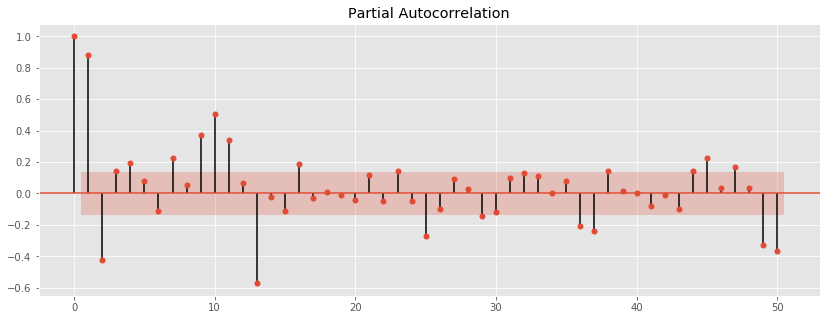

In [63]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(train, lags=50);

## ACF

### Natural Gas

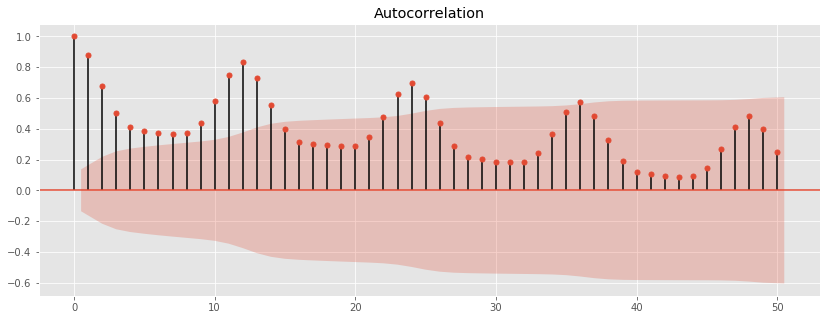

In [64]:
rcParams['figure.figsize'] = 14, 5

plot_acf(train, lags=50);

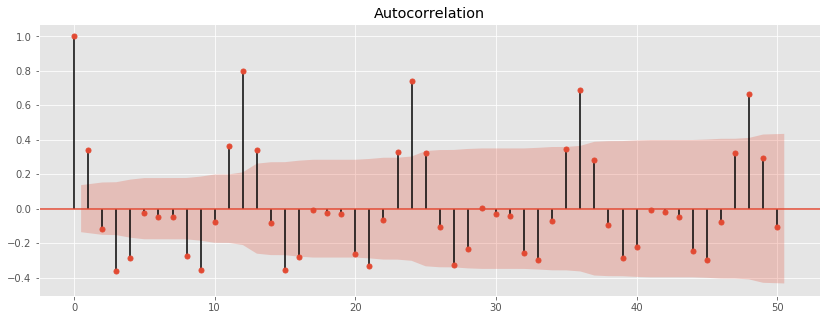

In [65]:
rcParams['figure.figsize'] = 14, 5

plot_acf(nat_diff, lags=50);

### PACF with first difference

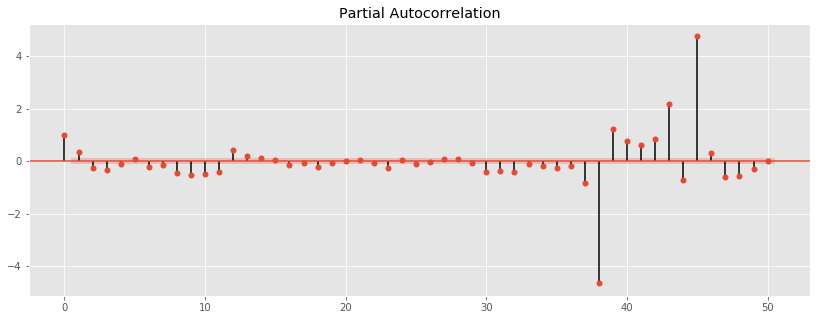

In [66]:
nat_diff = nat.diff(periods=1)
nat_diff.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff, lags=50);

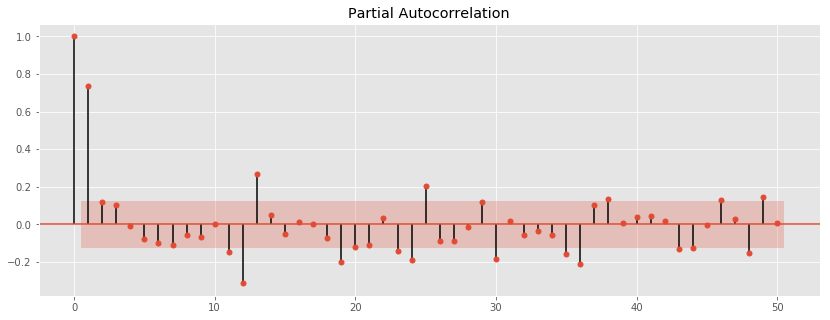

In [67]:
nat_diff = nat.diff(periods=12)
nat_diff.dropna(inplace=True)
rcParams['figure.figsize'] = 14, 5

plot_pacf(nat_diff, lags=50);

> look into this, why with periods = 12 the pacf makes much mores sense

> another idea create a DF with one column per source and then see if there is correlation between them
> the correlation can be seen with df.corr( ) and I can also do it on the series that are differenced

From here on we will dig deeper into natural gas as it is higher in production and is a more stable source of energy since it does not depend on uncontrollable factors like weather, which is the case for solar and wind.
We might go back to solar and wind after finished with Natural if there is time.

# Modeling

## Baseline Model:

In [68]:
naive = train.shift(1)
naive

date
2001-01-01           NaN
2001-02-01     42.388663
2001-03-01     37.966927
2001-04-01     44.364414
2001-05-01     45.842746
                 ...    
2017-11-01    106.826275
2017-12-01     94.928341
2018-01-01    111.397792
2018-02-01    110.292909
2018-03-01     98.511852
Name: Generation (TWh), Length: 207, dtype: float64

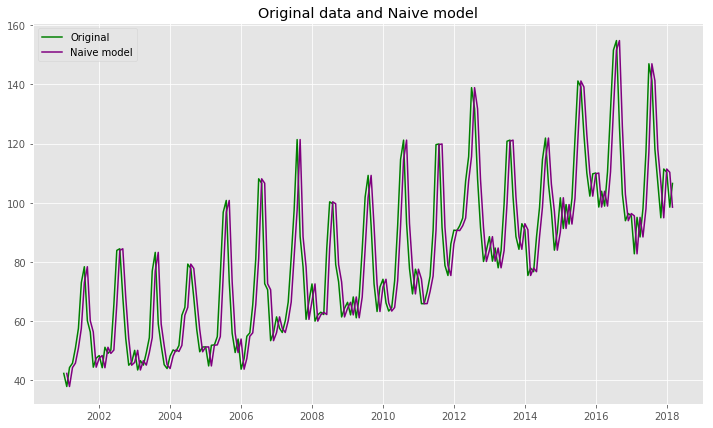

In [69]:
fig = plt.figure(figsize=(12,7))
plt.plot(train, color='green', label='Original')
plt.plot(naive, color='purple', label='Naive model')
#plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Original data and Naive model')
plt.show(block=False)

For a baseline to compare our later models, lets calculate our¬†RMSE
¬†for the naive model.

In [70]:
RMSE_naiv=round(np.sqrt(mean_squared_error(train[1:], naive.dropna())),2)
print(f'{Fore.BLUE}The RMSE fo the naive baseline model is: {RMSE_naiv}{Style.RESET_ALL}')

The RMSE fo the naive baseline model is: 12.32


## ARMA models

### AR model

In [71]:
mod_ar = ARIMA(train, order=(1,0,0))

In [72]:
# Fit the model to data
res_ar = mod_ar.fit()

In [73]:
# Print out summary information on the fit
res_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -808.522
Date:                Wed, 15 Mar 2023   AIC                           1623.044
Time:                        18:11:57   BIC                           1633.042
Sample:                    01-01-2001   HQIC                          1627.087
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.5313      7.535     10.687      0.000      65.762      95.300
ar.L1          0.8870      0.033     26.675      0.000       0.822       0.952
sigma2       143.5185     14.440      9.939      0.000     115.217     171.820
===================================================================================
Ljung-Box (L1) (Q):                  29.19   Jarque-Bera (JB):                 1.52
Prob(Q):                              0.00   Prob(JB):                         0.47
Heteroskedasticity (H):               1.35   Skew:                             0.21
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
# Print out the estimate for the constant and for theta
print(res_ar.params)

const      80.531265
ar.L1       0.886972
sigma2    143.518486
dtype: float64


In [75]:
aics=[]
aics.append(['armd', res_ar.aic])
res_ar.aic

1623.0442763976707

In [76]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return round(np.sqrt(mean_squared_error(train_data, y_hat)),2)

In [77]:
rmses=[]
rmses.append(['armd',find_rmse(res_ar)] )
print(find_rmse(res_ar))

12.21


### Random Walk

In [78]:
rw = ARIMA(train, order=(0,1,0))

In [79]:
# Fit the model to data
res_rw = rw.fit()

In [80]:
# Print out summary information on the fit
res_rw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -809.685
Date:                Wed, 15 Mar 2023   AIC                           1621.369
Time:                        18:11:57   BIC                           1624.697
Sample:                    01-01-2001   HQIC                          1622.715
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       151.8956     15.111     10.052      0.000     122.279     181.512
===================================================================================
Ljung-Box (L1) (Q):                  24.64   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.00   Prob(JB):                         0.53
Heteroskedasticity (H):               1.38   Skew:                            -0.19
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
aics.append(['rwlk', res_rw.aic])
res_rw.aic

1621.369318497057

In [82]:
rmses.append(['rwlk',find_rmse(res_rw)] )
print(find_rmse(res_rw))

12.64


### AR with First Difference

In [83]:
mod_arfd = ARIMA(train, order=(1,1,0))

In [84]:
# Fit the model to data
res_arfd = mod_arfd.fit()

In [85]:
# Print out summary information on the fit
res_arfd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -796.759
Date:                Wed, 15 Mar 2023   AIC                           1597.518
Time:                        18:11:57   BIC                           1604.174
Sample:                    01-01-2001   HQIC                          1600.210
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3430      0.068      5.039      0.000       0.210       0.476
sigma2       133.8912     12.171     11.000      0.000     110.036     157.747
===================================================================================
Ljung-Box (L1) (Q):                   1.82   Jarque-Bera (JB):                12.40
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.55
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
aics.append(['arfd', res_arfd.aic])
res_arfd.aic

1597.5180605192918

In [87]:
rmses.append(['arfd',find_rmse(res_arfd)] )
print(find_rmse(res_arfd))

11.91


### ARMA with first difference

In [88]:
mod_arma = ARIMA(train, order=(1,1,1))

In [89]:
# Fit the model to data
res_arma = mod_arma.fit()

In [90]:
# Print out summary information on the fit
res_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -793.475
Date:                Wed, 15 Mar 2023   AIC                           1592.950
Time:                        18:11:58   BIC                           1602.933
Sample:                    01-01-2001   HQIC                          1596.987
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0746      0.164      0.455      0.649      -0.247       0.396
ma.L1          0.3375      0.147      2.300      0.021       0.050       0.625
sigma2       129.6560     12.546     10.334      0.000     105.066     154.246
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.66
Prob(Q):                              0.93   Prob(JB):                         0.04
Heteroskedasticity (H):               1.41   Skew:                            -0.42
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
aics.append(['arma', res_arma.aic])
res_arma.aic

1592.9496080854847

In [92]:
rmses.append(['arma',find_rmse(res_arma)] )
print(find_rmse(res_arma))

11.74


In [93]:
aics

[['armd', 1623.0442763976707],
 ['rwlk', 1621.369318497057],
 ['arfd', 1597.5180605192918],
 ['arma', 1592.9496080854847]]

In [94]:
rmses

[['armd', 12.21], ['rwlk', 12.64], ['arfd', 11.91], ['arma', 11.74]]

### Trying higher orders

#### 211

In [95]:
mod_arma211 = ARIMA(train, order=(2,1,1))

In [96]:
# Fit the model to data
res_arma211 = mod_arma211.fit()

In [97]:
# Print out summary information on the fit
res_arma211.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -765.855
Date:                Wed, 15 Mar 2023   AIC                           1539.711
Time:                        18:11:58   BIC                           1553.022
Sample:                    01-01-2001   HQIC                          1545.094
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1311      0.065     17.443      0.000       1.004       1.258
ar.L2         -0.5445      0.059     -9.232      0.000      -0.660      -0.429
ma.L1         -0.9233      0.037    -24.912      0.000      -0.996      -0.851
sigma2        98.4548      9.897      9.948      0.000      79.057     117.852
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.39   Prob(JB):                         0.73
Heteroskedasticity (H):               1.38   Skew:                             0.13
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
aics.append(['arma211', res_arma211.aic])
res_arma211.aic

1539.7106340464702

In [99]:
rmses.append(['arma211',find_rmse(res_arma211)] )
print(find_rmse(res_arma211))

10.34


#### 212

In [100]:
mod_arma212 = ARIMA(train, order=(2,1,2))

In [101]:
res_arma212 = mod_arma212.fit()

In [102]:
res_arma212.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -765.403
Date:                Wed, 15 Mar 2023   AIC                           1540.805
Time:                        18:11:58   BIC                           1557.445
Sample:                    01-01-2001   HQIC                          1547.535
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2238      0.126      9.706      0.000       0.977       1.471
ar.L2         -0.6165      0.105     -5.865      0.000      -0.822      -0.410
ma.L1         -1.0557      0.158     -6.662      0.000      -1.366      -0.745
ma.L2          0.1280      0.150      0.851      0.395      -0.167       0.423
sigma2        97.9879      9.828      9.970      0.000      78.725     117.251
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.41
Prob(Q):                              0.75   Prob(JB):                         0.81
Heteroskedasticity (H):               1.38   Skew:                             0.11
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
aics.append(['arma212', res_arma212.aic])
res_arma212.aic

1540.8052386695467

In [104]:
rmses.append(['arma212',find_rmse(res_arma212)] )
print(find_rmse(res_arma212))

10.32


#### 214

In [105]:
mod_arma214 = ARIMA(train, order=(2,1,4))

In [106]:
res_arma214 = mod_arma214.fit()

In [107]:
res_arma214.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(2, 1, 4)   Log Likelihood                -763.744
Date:                Wed, 15 Mar 2023   AIC                           1541.489
Time:                        18:11:59   BIC                           1564.784
Sample:                    01-01-2001   HQIC                          1550.910
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0615      0.267     -0.230      0.818      -0.585       0.462
ar.L2         -0.0879      0.183     -0.480      0.631      -0.447       0.271
ma.L1          0.2887      0.251      1.151      0.250      -0.203       0.780
ma.L2         -0.1247      0.139     -0.895      0.371      -0.398       0.149
ma.L3         -0.4930      0.095     -5.199      0.000      -0.679      -0.307
ma.L4         -0.4449      0.107     -4.163      0.000      -0.654      -0.235
sigma2        96.4357      9.528     10.121      0.000      77.761     115.111
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 2.90
Prob(Q):                              0.74   Prob(JB):                         0.23
Heteroskedasticity (H):               1.24   Skew:                             0.27
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
aics.append(['arma214', res_arma214.aic])
res_arma214.aic

1541.4889297105426

In [109]:
rmses.append(['arfma214',find_rmse(res_arma214)] )
print(find_rmse(res_arma214))

10.25


#### 015

In [110]:
mod_arma015 = ARIMA(train, order=(0,1,5))

In [111]:
res_arma015 = mod_arma015.fit()

In [112]:
res_arma015.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(0, 1, 5)   Log Likelihood                -763.889
Date:                Wed, 15 Mar 2023   AIC                           1539.779
Time:                        18:11:59   BIC                           1559.746
Sample:                    01-01-2001   HQIC                          1547.854
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2244      0.061      3.677      0.000       0.105       0.344
ma.L2         -0.2100      0.066     -3.173      0.002      -0.340      -0.080
ma.L3         -0.4808      0.065     -7.426      0.000      -0.608      -0.354
ma.L4         -0.3849      0.078     -4.921      0.000      -0.538      -0.232
ma.L5          0.0487      0.086      0.564      0.573      -0.120       0.218
sigma2        96.5989      9.386     10.292      0.000      78.203     114.995
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 2.52
Prob(Q):                              0.77   Prob(JB):                         0.28
Heteroskedasticity (H):               1.25   Skew:                             0.25
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [113]:
aics.append(['arma015', res_arma015.aic])
aics

[['armd', 1623.0442763976707],
 ['rwlk', 1621.369318497057],
 ['arfd', 1597.5180605192918],
 ['arma', 1592.9496080854847],
 ['arma211', 1539.7106340464702],
 ['arma212', 1540.8052386695467],
 ['arma214', 1541.4889297105426],
 ['arma015', 1539.778813089486]]

In [114]:
rmses.append(['arma015',find_rmse(res_arma015)] )
rmses

[['armd', 12.21],
 ['rwlk', 12.64],
 ['arfd', 11.91],
 ['arma', 11.74],
 ['arma211', 10.34],
 ['arma212', 10.32],
 ['arfma214', 10.25],
 ['arma015', 10.26]]

## Grid search for ARIMA model

Defining a function to do a grid search on the ARIMA model.
<br>This function evaluates the model base on the AIC.

In [115]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models_aic(dataset, p_values, d_values, q_values):   
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order=order)
                    model_fit = model.fit()
                    aic=model_fit.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, order
                    print('ARIMA%s AIC=%.3f' % (order,aic))
                except:
                    continue
    print('Best ARIMA%s AIC=%.3f' % (best_cfg, best_score))

## First ARIMA grid search 

In [116]:
# evaluate parameters
p_values = [1, 2, 4, 6, 8]
d_values = range(1, 3)
q_values = range(1, 3)
warnings.filterwarnings("ignore")
evaluate_models_aic(train, p_values, d_values, q_values)

ARIMA(1, 1, 1) AIC=1592.950
ARIMA(1, 1, 2) AIC=1562.919
ARIMA(1, 2, 1) AIC=1597.197
ARIMA(1, 2, 2) AIC=1592.754
ARIMA(2, 1, 1) AIC=1539.711
ARIMA(2, 1, 2) AIC=1540.805
ARIMA(2, 2, 1) AIC=1584.169
ARIMA(2, 2, 2) AIC=1531.569
ARIMA(4, 1, 1) AIC=1568.974
ARIMA(4, 1, 2) AIC=1544.112
ARIMA(4, 2, 1) AIC=1571.912
ARIMA(4, 2, 2) AIC=1575.532
ARIMA(6, 1, 1) AIC=1516.308
ARIMA(6, 1, 2) AIC=1454.412
ARIMA(6, 2, 1) AIC=1561.556
ARIMA(6, 2, 2) AIC=1511.849
ARIMA(8, 1, 1) AIC=1472.259
ARIMA(8, 1, 2) AIC=1401.174
ARIMA(8, 2, 1) AIC=1524.379
ARIMA(8, 2, 2) AIC=1469.653
Best ARIMA(8, 1, 2) AIC=1401.174


### Best model from first ARIMA search

In [117]:
model_1stgrd = ARIMA(train, order=(8,1,2)).fit()
model_1stgrd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                 ARIMA(8, 1, 2)   Log Likelihood                -689.587
Date:                Wed, 15 Mar 2023   AIC                           1401.174
Time:                        18:12:08   BIC                           1437.781
Sample:                    01-01-2001   HQIC                          1415.979
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9880      0.058     17.130      0.000       0.875       1.101
ar.L2         -0.8937      0.086    -10.412      0.000      -1.062      -0.725
ar.L3          0.0402      0.101      0.396      0.692      -0.159       0.239
ar.L4         -0.1553      0.108     -1.432      0.152      -0.368       0.057
ar.L5         -0.0060      0.116     -0.052      0.958      -0.233       0.221
ar.L6         -0.5006      0.119     -4.209      0.000      -0.734      -0.268
ar.L7          0.3874      0.102      3.812      0.000       0.188       0.587
ar.L8         -0.6249      0.063     -9.849      0.000      -0.749      -0.501
ma.L1         -1.1537      0.047    -24.397      0.000      -1.246      -1.061
ma.L2          0.8077      0.047     17.223      0.000       0.716       0.900
sigma2        45.6568      4.654      9.809      0.000      36.534      54.779
===================================================================================
Ljung-Box (L1) (Q):                   5.35   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.02   Prob(JB):                         0.74
Heteroskedasticity (H):               1.16   Skew:                             0.13
Prob(H) (two-sided):                  0.54   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

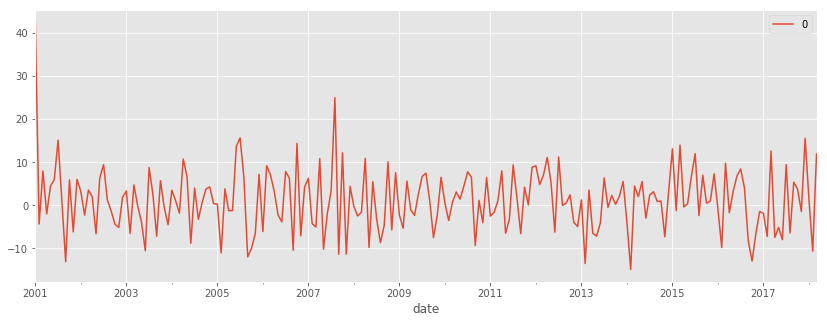

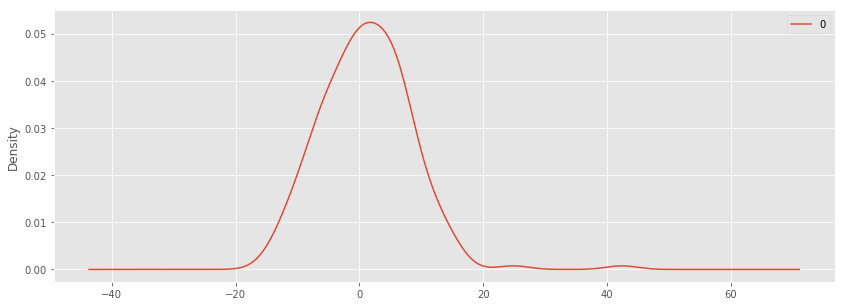

                0
count  207.000000
mean     1.086978
std      7.385014
min    -14.989805
25%     -4.056800
50%      0.977447
75%      5.893020
max     42.388663


In [118]:
# line plot of residuals
residuals = pd.DataFrame(model_1stgrd.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())


In [119]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.364970
p-value                          0.000342
#Lags Used                      12.000000
Number of Observations Used    194.000000
Critical Value (1%)             -3.464515
Critical Value (5%)             -2.876556
Critical Value (10%)            -2.574775
dtype: float64


In [120]:
print(f'{Fore.GREEN}The RMSE for the best ARMA model after first grid, \
on the train is:{find_rmse(model_1stgrd)}{Style.RESET_ALL}')

The RMSE for the best ARMA model after first grid, on the train is:7.45


This is a good result considering that the RMSE for the naive model was around 12.
But we are fitting the model on the whole train and making predictions on it. To get more authentic results that can actually tell us more of what would happen with unseen data, let us do some cross validation.
As we have seen about we have created already some splits of the train set, into train and validation. Now we are going to use those splits.
### Cross Validation

In [121]:
train.index

DatetimeIndex(['2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01',
               '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01',
               '2001-09-01', '2001-10-01',
               ...
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01'],
              dtype='datetime64[ns]', name='date', length=207, freq=None)

In [122]:
train_with_ind = train.reset_index()

In [123]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    #fitting on the train from the train-validation split
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(8, 1, 2)).fit()
    #predicting on the validation part of the sample
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    #comparing validation and predictions on validation
    print(np.sqrt(mean_squared_error(true, preds)))

12.708135814845262
11.213173508277036
16.513312146403646
11.213621195887724
13.992694000579876


In [124]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation: 13.13


These values of RMSE are higher because this time I am doing a cross validation and I am not fitting on the validation set but only on the train.
Not as great but more accurate because we are not fitting

Let us see if we can improve this even further buy doing one more ARIMA search.

## Second grid search for ARIMA

In [125]:
# evaluate parameters
p_values = [8, 10, 12, 20]
d_values = [1,2]
q_values = [1,2]
warnings.filterwarnings("ignore")
evaluate_models_aic(train.values, p_values, d_values, q_values)

ARIMA(8, 1, 1) AIC=1472.259
ARIMA(8, 1, 2) AIC=1401.174
ARIMA(8, 2, 1) AIC=1524.379
ARIMA(8, 2, 2) AIC=1469.653
ARIMA(10, 1, 1) AIC=1430.631
ARIMA(10, 1, 2) AIC=1382.235
ARIMA(10, 2, 1) AIC=1428.363
ARIMA(10, 2, 2) AIC=1405.720
ARIMA(12, 1, 1) AIC=1355.815
ARIMA(12, 1, 2) AIC=1357.197
ARIMA(12, 2, 1) AIC=1363.006
ARIMA(12, 2, 2) AIC=1365.921
ARIMA(20, 1, 1) AIC=1359.881
ARIMA(20, 1, 2) AIC=1361.479
ARIMA(20, 2, 1) AIC=1364.163
ARIMA(20, 2, 2) AIC=1361.240
Best ARIMA(12, 1, 1) AIC=1355.815


Taking the best model from this search

In [126]:
model_2ndgrd = ARIMA(train, order=(12, 1, 1)).fit()
model_2ndgrd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Generation (TWh)   No. Observations:                  207
Model:                ARIMA(12, 1, 1)   Log Likelihood                -663.908
Date:                Wed, 15 Mar 2023   AIC                           1355.815
Time:                        18:12:33   BIC                           1402.406
Sample:                    01-01-2001   HQIC                          1374.658
                         - 03-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0511      0.111      0.460      0.645      -0.167       0.269
ar.L2         -0.1727      0.067     -2.591      0.010      -0.303      -0.042
ar.L3         -0.1214      0.075     -1.618      0.106      -0.268       0.026
ar.L4         -0.1622      0.073     -2.219      0.027      -0.305      -0.019
ar.L5         -0.0405      0.078     -0.520      0.603      -0.193       0.112
ar.L6         -0.2044      0.070     -2.928      0.003      -0.341      -0.068
ar.L7         -0.0552      0.085     -0.651      0.515      -0.222       0.111
ar.L8         -0.1402      0.073     -1.933      0.053      -0.282       0.002
ar.L9         -0.1792      0.075     -2.376      0.017      -0.327      -0.031
ar.L10        -0.0919      0.070     -1.319      0.187      -0.229       0.045
ar.L11         0.0114      0.072      0.160      0.873      -0.129       0.152
ar.L12         0.5896      0.069      8.582      0.000       0.455       0.724
ma.L1         -0.2692      0.129     -2.089      0.037      -0.522      -0.017
sigma2        34.2525      3.346     10.237      0.000      27.695      40.810
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.54
Prob(Q):                              0.91   Prob(JB):                         0.17
Heteroskedasticity (H):               1.11   Skew:                             0.17
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

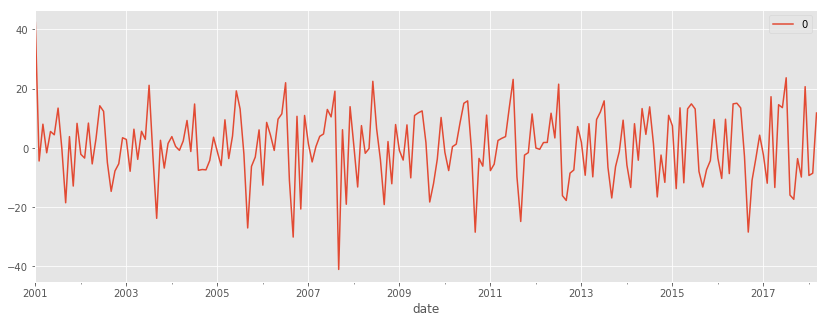

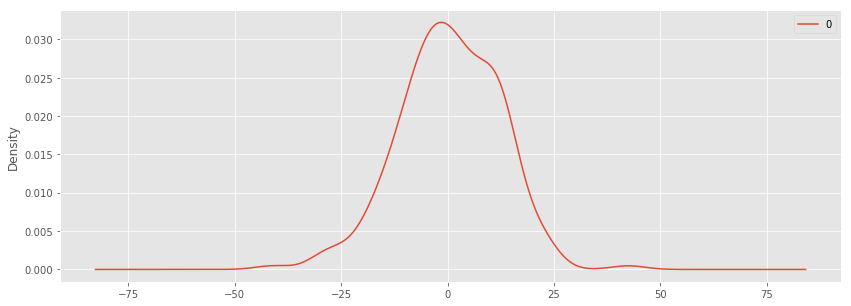

                0
count  207.000000
mean     0.435011
std     11.756272
min    -41.044733
25%     -7.338286
50%      0.465362
75%      9.421939
max     42.388663


In [127]:
# line plot of residuals
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [128]:
residuals.dropna(inplace=True)
dftest = adfuller(residuals)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',\
        'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print ('Results of Dickey-Fuller test: \n')
print(dfoutput)

Results of Dickey-Fuller test: 

Test Statistic                  -4.075838
p-value                          0.001062
#Lags Used                      15.000000
Number of Observations Used    191.000000
Critical Value (1%)             -3.465059
Critical Value (5%)             -2.876794
Critical Value (10%)            -2.574901
dtype: float64


In [129]:
print(f'{Fore.BLUE}The RMSE for the best ARMA model after first grid, \
on the train is:{find_rmse(model_2ndgrd)}{Style.RESET_ALL}')

The RMSE for the best ARMA model after first grid, on the train is:6.74


### Cross Validation:

In [130]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(12, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

13.898437634188952
10.22430482717282
15.665953367079544
18.941225204991735
12.492753763528457


In [131]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation: 14.24


There is something else happening in our time series that we haven't taken into account yet, and definitely plays a major role: seasonality.
So let us try now using a SARIMAX model which includes also 4 more terms, to account for seasonality.

# Including Seasonality: SARIMAX

> Add a paragraph that explains why we need to do this and why it's powerful.

## First Grid Search SARIMAX

In [132]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [1, 2, 4,  6, 8]
d = [1, 2, 4]
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


The output of our code suggests that ARIMA (1, 1, 1) x (1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

It is very time consuming to run all of the options so we pickled the GridSearchCV models after we ran them and fit them.
The pickled files were also too large for the Github Repository so we had to remove them.
We show below all the code that was used for demonastrative purposes, but we comment it out and keep only the results of the search.


In [133]:
"""CODE that was used to conduct the SARIMAX grid search:

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

"CODE that was used to conduct the SARIMAX grid search:\n\nans = []\nfor comb in pdq:\n    for combs in pdqs:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(train,\n                                            order=comb,\n                                            seasonal_order=combs,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            output = mod.fit()\n            ans.append([comb, combs, output.aic])\n            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))\n        except:\n            continue"

In [134]:
"""CODE used to extract the model with lowest AIC

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

"CODE used to extract the model with lowest AIC\n\n# Find the parameters with minimal AIC value\nans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])\nans_df.loc[ans_df['aic'].idxmin()]"

In [135]:
# CODE used to pickle df of results
# ans_df.to_pickle("./SARgrid1.pkl")

In [136]:
res_grid_df = pd.read_pickle("./SARgrid1.pkl")  

In [137]:
res_grid_df.sort_values(by='aic').head(10)

pdq           pdqs         aic
838  (8, 2, 2)  (8, 4, 1, 12)  390.300560
568  (6, 1, 1)  (8, 4, 1, 12)  401.144101
749  (8, 1, 1)  (8, 4, 2, 12)  404.020123
598  (6, 1, 2)  (8, 4, 1, 12)  406.228081
779  (8, 1, 2)  (8, 4, 2, 12)  407.293806
388  (4, 1, 1)  (8, 4, 1, 12)  412.478274
569  (6, 1, 1)  (8, 4, 2, 12)  412.843780
599  (6, 1, 2)  (8, 4, 2, 12)  415.171388
839  (8, 2, 2)  (8, 4, 2, 12)  416.268315
628  (6, 2, 1)  (8, 4, 1, 12)  424.192994

## Best SARIMAX model after first grid search

In [138]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [139]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA_MODEL1 =SARIMAX(train, 
                        order=(8, 2, 2), 
                        seasonal_order=(8, 4, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

# Fit the model and print results
output1 = SARIMA_MODEL1.fit()

print(output1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5381      0.991     -0.543      0.587      -2.480       1.404
ar.L2         -0.0563      0.567     -0.099      0.921      -1.167       1.054
ar.L3         -0.2800      0.383     -0.732      0.464      -1.030       0.470
ar.L4         -0.1306      0.456     -0.287      0.774      -1.024       0.763
ar.L5          0.3590      0.306      1.174      0.241      -0.241       0.959
ar.L6         -0.0661      0.368     -0.180      0.857      -0.787       0.655
ar.L7         -0.4037      0.228     -1.772      0.076      -0.850       0.043
ar.L8          0.0868      0.466      0.186      0.852      -0.827       1.000
ma.L1         -0.8643      0.889     -0.972      0.331      -2.607       0.879
ma.L2         -0.4374      1.056     -0.414      0.679      -2.508       1.633
ar.S.L12      -2.2225      0.228     -9.764      0.0

The model returns a lot of information, but we'll focus only on the table of coefficients. The coef column above shows the importance of each feature and how each one impacts the time series patterns. The  ùëÉ>|ùëß|
  provides the significance of each feature weight.

For our time-series, we see that each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

In [140]:
y_hat_train1 = output1.predict(typ='levels')
RMSE_train1=np.sqrt(mean_squared_error(train, y_hat_train1))
RMSE_train1
#8.93

20.61406919389055

Next, we shall run model diagnostics to ensure that none of the assumptions made by the model have been violated.

Call the .plot_diagnostics( ) method on ARIMA output below:

In [141]:
# Call plot_diagnostics() on the results calculated above 
#output1.plot_diagnostics(figsize=(15, 18))
#plt.show()

The purpose here is to ensure that residuals remain uncorrelated, normally distributed having zero mean. In the absence of these assumptions, we can not move forward and need further tweaking of the model.

Let's check for these assumptions from diagnostics plots.

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

#### Cross Validation

In [142]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      #engod like this means he's fitting on the train
                      order=(8, 2, 2), 
                    seasonal_order=(8, 4, 1, 12), 
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    #predicting on the validation slice of the sample
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    #comparing validation and predictions on validation
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

459.47352067573576
1439.5228973231533
644.4040220080257
288.62061973835614
182.37465170087768


mean : 602

In [143]:
mean=round(np.mean(cv),2)
print(f'{Fore.RED}Mean of RMSE after cross validation: {mean}{Style.RESET_ALL}')

Mean of RMSE after cross validation: 602.88


We actually calculated the RMSE with cross validation for more than this one model, but for reasons of brevity and running time of the notebook, we are omitting those calculations, as they led to a very similar result.

## Second Grid Search SARIMAX:

In [144]:
# Define the p, d and q parameters to take any value between 0 and 2
p = [8, 12]
d = range(1,3)
q = range(1,3)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [145]:
"""CODE used for the second grid search

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue"""

"CODE used for the second grid search\n\nans = []\nfor comb in pdq:\n    for combs in pdqs:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(train,\n                                            order=comb,\n                                            seasonal_order=combs,\n                                            enforce_stationarity=False,\n                                            enforce_invertibility=False)\n\n            output = mod.fit()\n            ans.append([comb, combs, output.aic])\n            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))\n        except:\n            continue"

In [146]:
"""Results of the second grid search

# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]"""

"Results of the second grid search\n\n# Find the parameters with minimal AIC value\nans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])\nans_df.loc[ans_df['aic'].idxmin()]"

In [147]:
#Pickling the results of the second grid search
#ans_df.to_pickle("./SARgs.pkl")

In [148]:
results_df = pd.read_pickle("./SARgs.pkl")  

In [149]:
results_df.sort_values(by='aic').head(10)

pdq            pdqs         aic
14  (8, 1, 2)  (12, 2, 1, 12)  173.506577
7   (8, 1, 1)  (12, 2, 2, 12)  180.441275
6   (8, 1, 1)  (12, 2, 1, 12)  181.372341
30  (8, 2, 2)  (12, 2, 1, 12)  184.947537
23  (8, 2, 1)  (12, 2, 2, 12)  185.479998
22  (8, 2, 1)  (12, 2, 1, 12)  185.748173
15  (8, 1, 2)  (12, 2, 2, 12)  188.303187
31  (8, 2, 2)  (12, 2, 2, 12)  199.936131
28  (8, 2, 2)  (12, 1, 1, 12)  225.506853
29  (8, 2, 2)  (12, 1, 2, 12)  234.166871

As we can see the AIC values are all lower than the AICs from the first grid search.

## Best SARIMAX model 2nd grid search

In [150]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA_MODEL2 = SARIMAX(train, 
                        order=(8, 1, 2), 
                        seasonal_order=(12, 2, 1, 12), 
                        enforce_stationarity=True, 
                        enforce_invertibility=True)

# Fit the model and print results
output2 = SARIMA_MODEL2.fit()

output2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [151]:
y_hat_train2 = output2.predict(typ='levels')
RMSE_train2=np.sqrt(mean_squared_error(train, y_hat_train2))
RMSE_train2

7.533589098988136

In [152]:
cv=[]
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      #engod like this means he's fitting on the train
                      order=(8, 1, 2), 
                        seasonal_order=(12, 2, 1, 12), 
                     enforce_stationarity=True,
                     enforce_invertibility=True).fit()
    #predicting on the validation slice of the sample
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    #comparing validation and predictions on validation
    true = train_with_ind.iloc[val_ind, -1]
    cv.append(round(np.sqrt(mean_squared_error(true, preds)),2))
    print(np.sqrt(mean_squared_error(true, preds)))

47.32479818047728
37.30616363413895
9.566750980222713
17.344266346089785
10.804881953711952


In [153]:
mean=np.mean(cv)
mean

24.467999999999996

In [154]:
mean=np.mean(cv)
mean

24.467999999999996

In [155]:
mean:53

We actually calculated the RMSE with cross validation for more than this one model, but for reasons of brevity and running time of the notebook, we are omitting those calculations, as they led to a very similar result.

#### In terms of the RMSE:
The first 5 models from the 2 grid searches are worse than the naive model.
<br>The sixth one is better than the naive model, but still worse than our top model from the ARIMA search.
#### In terms of AIC:
The ARMA models (before the SARIMAX searches) all had AICs above 1000.
<br>The models from the SARIMAX grid search have all AICs below 400.

## I can also add here because we still have these 2 models competing I can do a second type of validation, taking 1 year from the test and using it as validation.
#### Which metric
There is a substantial difference between these two metrics, and we will use them both to evaluate our best two models and see which one performs best on the validation set.

We want the AIC to be low because it gives us a sense of the overall goodness of the model and penalizes models that are too complex, so it should prevent overfitting.
<br>We also want the RMSE to be low because that is what ultimately tells us how well the model is performing, compared to the data.

Because of this we will take the model with the overall best RMSE, and the one with the lowest AIC and compare them.
<br>These are the model after the second ARIMA search, with parameters (12, 1, 1), with RMSE 6.74, and the model after the second SARIMAX search, with parameters (8, 1, 2)	(12, 2, 1, 12) and AIC	173.5.

We will ultimately choose the model with the lowest RMSE (when we are testing the model on the test set) since that is what we want as our final goal: a model that fits as well as possible the data.

# Greg

Then he predicts on the test:

In [156]:
# Plug the optimal parameter values into a new SARIMAX model
SARIMA = SARIMAX(train, 
                order=(8, 1, 2), 
                seasonal_order=(12, 2, 1, 12), 
                enforce_stationarity=True, 
                enforce_invertibility=True)

# Fit the model and print results
output = SARIMA.fit()

In [157]:
nat_cut=nat['2010-01-01':]

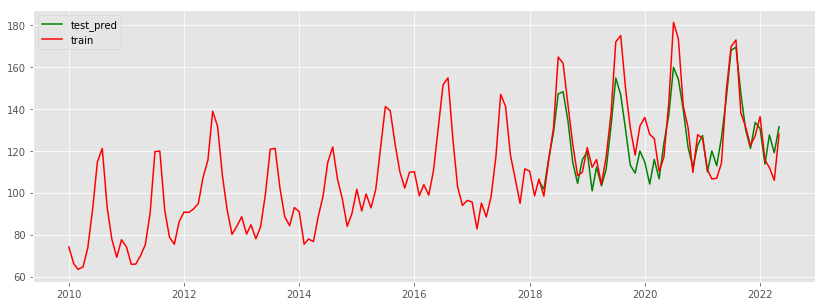

In [158]:
#note sari mode was only fitted on the train
y_hat_train = output.get_prediction(typ='levels')
y_hat_test = output.get_prediction(start=pd.to_datetime('2018-03-01'), \
                        end=pd.to_datetime('2022-05-01'), dynamic=False, full_results=True)
#y_hat_test = output4.predict(start=pd.to_datetime('2001-01-01'),\
#                end=pd.to_datetime('2018-03-01'), dynamic=True, full_results=True)
fig, ax = plt.subplots()

#ax.plot(test, label='test', color='')
#ax.plot(y_hat_train, label='train_pred')
ax.plot(y_hat_test.predicted_mean, label='test_pred', color='g')
ax.plot(nat_cut, label='train', color='r')
plt.legend();

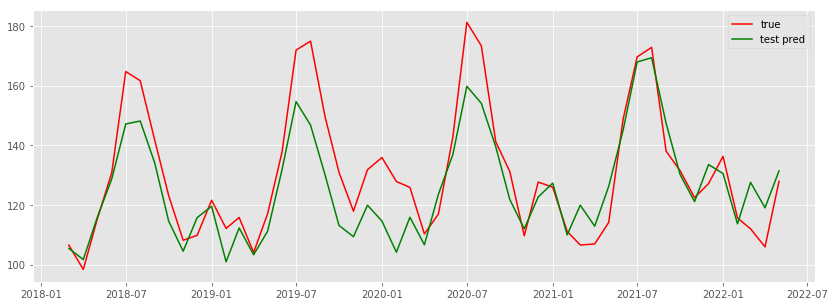

In [159]:
# Let's zoom in on test
fig, ax = plt.subplots()

ax.plot(test, label='true', color='r')
ax.plot(y_hat_test.predicted_mean, label='test pred', color='g')

plt.legend();

RMSE on the test

In [160]:
np.sqrt(mean_squared_error(test, y_hat_test.predicted_mean))

10.900637789208123

In [161]:
#print(forecast.summary_frame())

In [162]:
mode = ARIMA(train, order=(8,1,2)).fit()

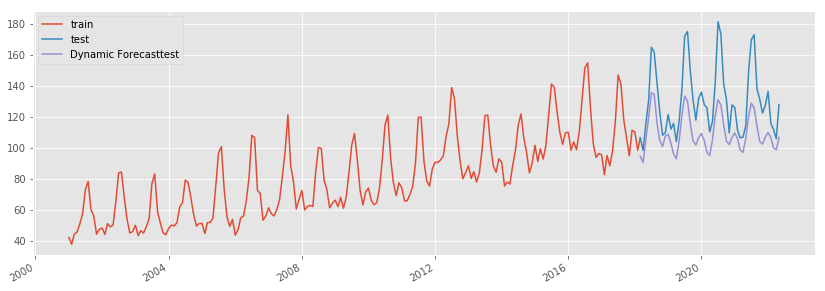

In [163]:
#pred_dynamic1 = mode.get_prediction(start=pd.to_datetime('2018-03-01'),\
 #               end=pd.to_datetime('2019-04-01'), dynamic=True, full_results=True)
#pred_dynamic_conf = pred_dynamic1.conf_int()
#note sari mode was only fitted on the train
y_hat_train = mode.get_prediction(start=pd.to_datetime('2001-01-01'),\
                end=pd.to_datetime('2018-03-01'), dynamic=True, full_results=True)
y_hat_test = mode.get_prediction(start=pd.to_datetime('2018-03-01'),\
                end=pd.to_datetime('2022-05-01'), dynamic=True, full_results=True)
fig, ax = plt.subplots()
ax.plot(train, label='train')
ax.plot(test, label='test')
#ax.plot(y_hat_train, label='train_pred')
#ax.plot(y_hat_test, label='test_pred')
#y_hat_train.predicted_mean.plot(label='Dynamic Forecast train', ax=ax)
y_hat_test.predicted_mean.plot(label='Dynamic Forecasttest', ax=ax)

plt.legend();

In [164]:
np.sqrt(mean_squared_error(test, y_hat_test.predicted_mean))

23.715932918560792

## Forecast:

In [165]:
#this time fit the chosen model on the whole set!
final = SARIMAX(nat,
                  order=(8, 1, 2), 
                  seasonal_order=(12, 2, 1, 12), 
                  enforce_stationarity=True,
                  enforce_invertibility=True).fit()

We need to set the number of steps. Every step is a month, if we want to predict 3 years in the future that is 36 steps.

In [166]:
forecast = final.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = forecast.conf_int()

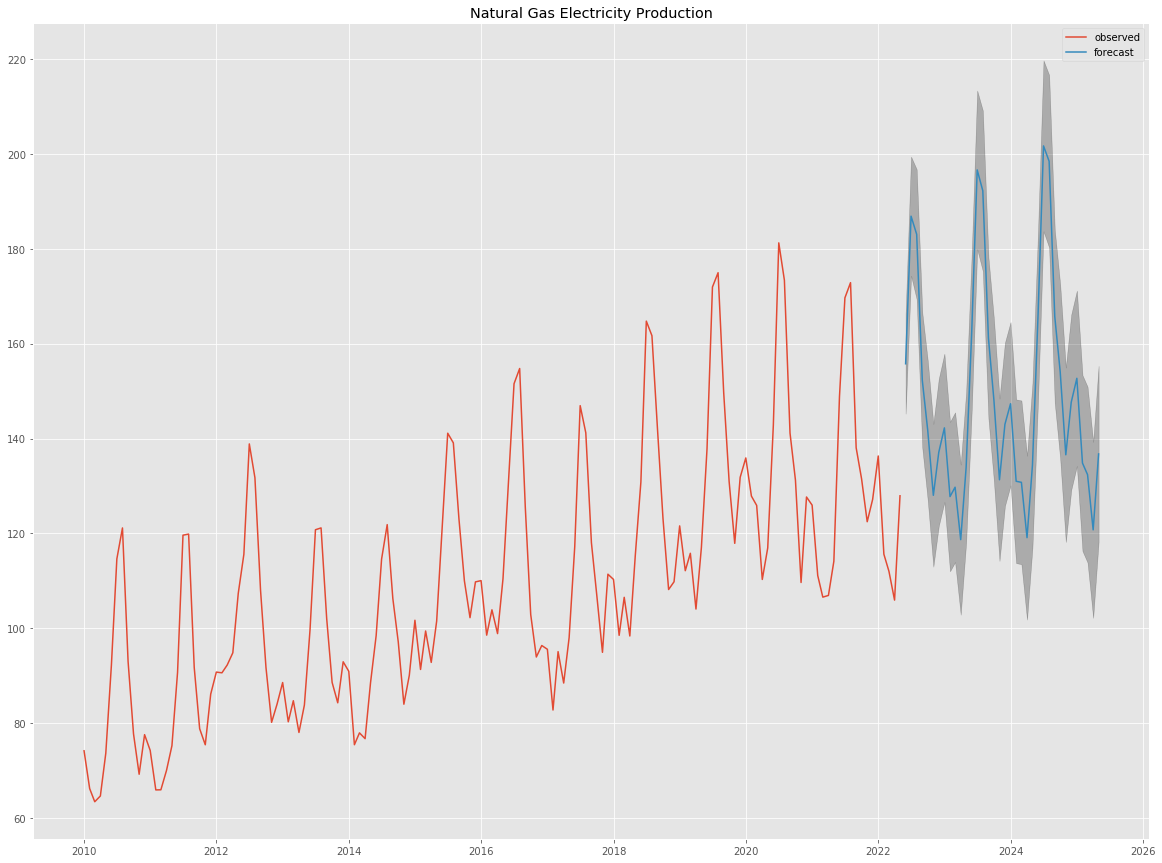

In [167]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot(nat_cut, label='observed')
ax.plot(forecast.predicted_mean, label='forecast')
ax.set_title('Natural Gas Electricity Production')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)

plt.legend();

In [168]:
print(forecast.summary_frame())

Generation (TWh)        mean   mean_se  mean_ci_lower  mean_ci_upper
2022-06-01        155.756269  5.361166     145.248578     166.263960
2022-07-01        186.873696  6.403075     174.323900     199.423492
2022-08-01        183.055237  6.990843     169.353437     196.757037
2022-09-01        152.286693  7.262868     138.051734     166.521652
2022-10-01        141.738122  7.515580     127.007856     156.468387
2022-11-01        128.030033  7.681373     112.974817     143.085248
2022-12-01        137.100233  7.912892     121.591251     152.609215
2023-01-01        142.245989  7.977247     126.610872     157.881106
2023-02-01        127.760662  8.035470     112.011431     143.509894
2023-03-01        129.738335  8.050874     113.958912     145.517759
2023-04-01        118.684768  8.076702     102.854723     134.514813
2023-05-01        133.942298  8.082203     118.101472     149.783124
2023-06-01        162.659768  8.424353     146.148339     179.171197
2023-07-01        196.626565  8.53

In [169]:
mode = ARIMA(nat, order=(8,1,2)).fit()

In [170]:
forecast = mode.forecast(steps=36)

# Get confidence intervals of forecasts
#pred_conf = forecast.conf_int()

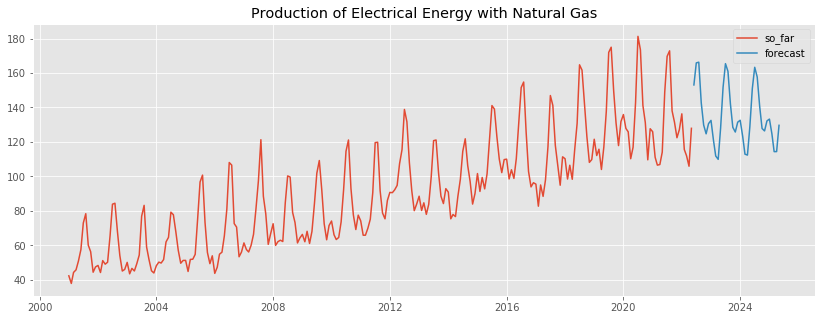

In [171]:
fig, ax = plt.subplots()
ax.plot(nat, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('Production of Electrical Energy with Natural Gas')

plt.legend();

## Study of seasonality and states:

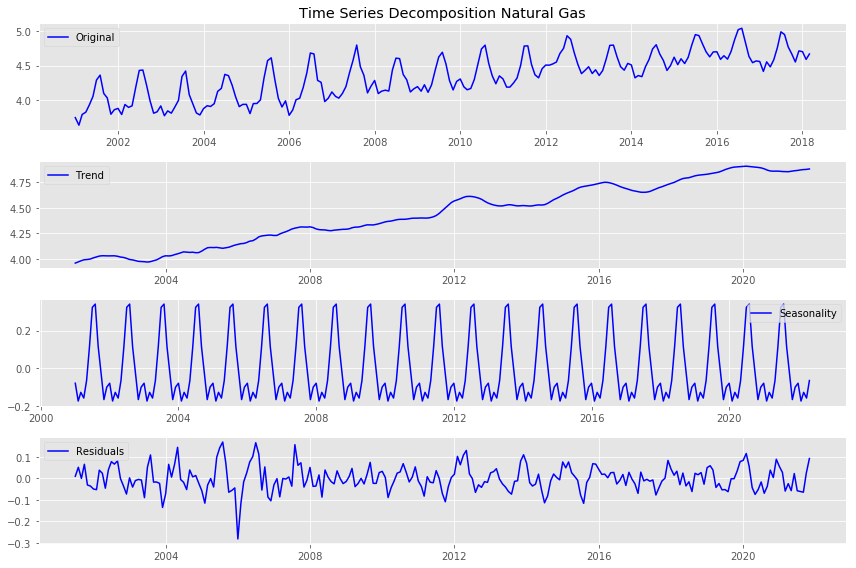

In [172]:
decomposition = seasonal_decompose(np.log(nat))

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.title('Time Series Decomposition Natural Gas')
plt.plot(np.log(train), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')

plt.tight_layout();

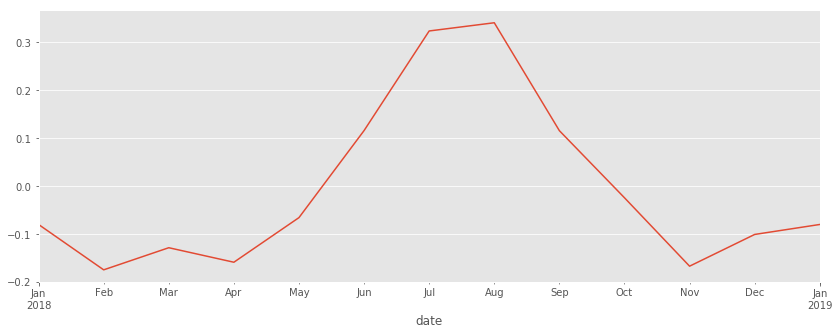

In [173]:
year=seasonal['2018-01-01':'2019-01-01']
year.plot();

In [174]:
df["Generation (TWh)"]=df["GENERATION (Megawatthours)"]/1000000
df.drop(['GENERATION (Megawatthours)'], axis=1, inplace=True)
#df

In [175]:
tot=df.loc[df['TYPE OF PRODUCER']=='Total Electric Power Industry']
natgas=tot.loc[tot['ENERGY SOURCE']=='Natural Gas']


In [176]:
#natgas

In [177]:
#nat_state

In [178]:
nat_states=natgas.groupby(by=["STATE"]).sum()
nat_states.drop('US-TOTAL', axis=0, inplace=True)
#nat_states

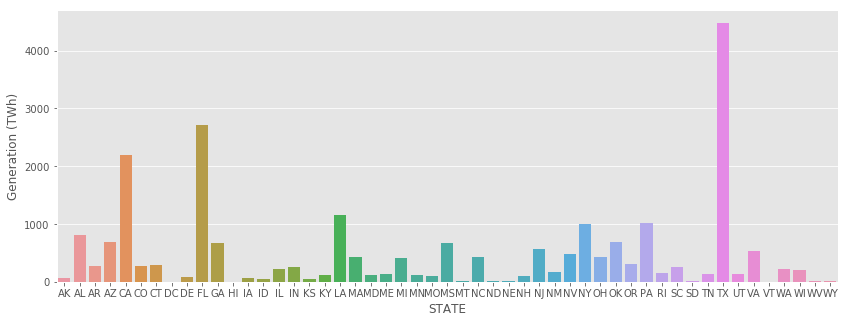

In [179]:
sns.barplot(x=nat_states.index, y=nat_states["Generation (TWh)"]);

In [180]:
top_10=nat_states.sort_values(by="Generation (TWh)", ascending=False).head(10)

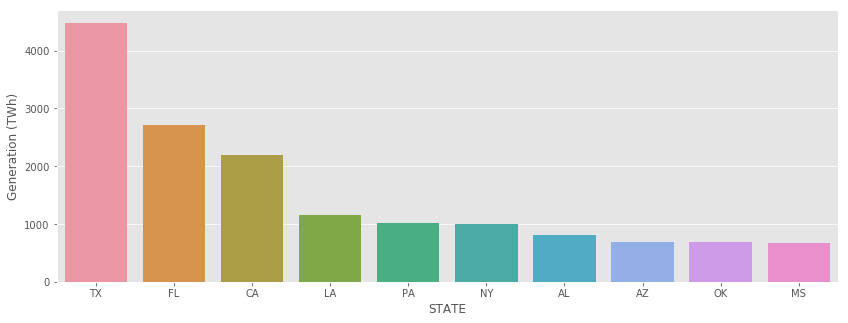

In [181]:
sns.barplot(x=top_10.index, y=top_10["Generation (TWh)"]);

In [182]:
TX=natgas.loc[natgas['STATE']=='TX']
FL=natgas.loc[natgas['STATE']=='FL']
PA=natgas.loc[natgas['STATE']=='PA']
WA=natgas.loc[natgas['STATE']=='WA']
IN=natgas.loc[natgas['STATE']=='IN']
MN=natgas.loc[natgas['STATE']=='MN']

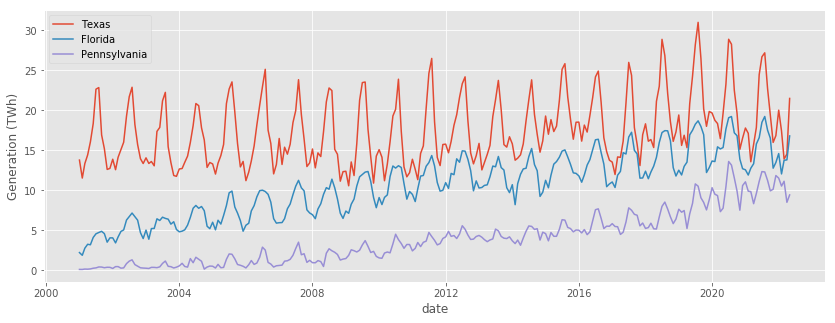

In [183]:
sns.lineplot(x=TX.index,y=TX["Generation (TWh)"])
sns.lineplot(x=FL.index,y=FL["Generation (TWh)"])
sns.lineplot(x=PA.index,y=PA["Generation (TWh)"])
plt.legend(labels=['Texas', 'Florida', 'Pennsylvania']);

In [184]:
TX

STATE               TYPE OF PRODUCER ENERGY SOURCE  \
date                                                            
2001-01-01    TX  Total Electric Power Industry   Natural Gas   
2001-02-01    TX  Total Electric Power Industry   Natural Gas   
2001-03-01    TX  Total Electric Power Industry   Natural Gas   
2001-04-01    TX  Total Electric Power Industry   Natural Gas   
2001-05-01    TX  Total Electric Power Industry   Natural Gas   
...          ...                            ...           ...   
2022-01-01    TX  Total Electric Power Industry   Natural Gas   
2022-02-01    TX  Total Electric Power Industry   Natural Gas   
2022-03-01    TX  Total Electric Power Industry   Natural Gas   
2022-04-01    TX  Total Electric Power Industry   Natural Gas   
2022-05-01    TX  Total Electric Power Industry   Natural Gas   

            Generation (TWh)  
date                          
2001-01-01         13.750546  
2001-02-01         11.507834  
2001-03-01         13.316335  
2001-04-01         14.402417  
2001-05-01         16.025878  
...                      ...  
2022-01-01         19.984717  
2022-02-01         17.382151  
2022-03-01         13.885423  
2022-04-01         14.501311  
2022-05-01         21.449423  

[257 rows x 4 columns]

Creating Series to do seasonal decomposition

In [185]:
TXs=TX["Generation (TWh)"]
PAs=PA['Generation (TWh)']
WAs=WA['Generation (TWh)']
MNs=MN['Generation (TWh)']
INs=IN['Generation (TWh)']

In [186]:
decomposition = seasonal_decompose(TXs)
seasonal_TX = decomposition.seasonal
yearTX=seasonal_TX['2018-01-01':'2019-01-01']

In [187]:
decomposition = seasonal_decompose(PAs)
seasonal_PA = decomposition.seasonal
yearPA=seasonal_PA['2018-01-01':'2019-01-01']

In [188]:
decomposition = seasonal_decompose(INs)
seasonal_IN = decomposition.seasonal
yearIN=seasonal_IN['2018-01-01':'2019-01-01']

In [189]:
decomposition = seasonal_decompose(WAs)
seasonal_WA = decomposition.seasonal
yearWA=seasonal_WA['2018-01-01':'2019-01-01']

In [190]:
decomposition = seasonal_decompose(MNs)
seasonal_MN = decomposition.seasonal
yearMN=seasonal_MN['2018-01-01':'2019-01-01']

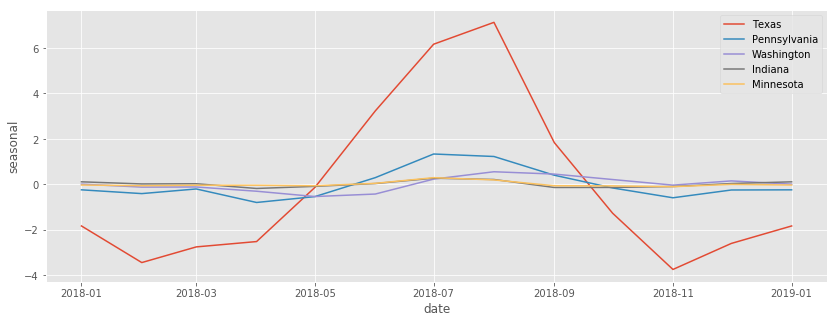

In [191]:
sns.lineplot(x=yearTX.index,y=yearTX)
sns.lineplot(x=yearPA.index,y=yearPA)
sns.lineplot(x=yearWA.index,y=yearWA)
sns.lineplot(x=yearIN.index,y=yearIN)
sns.lineplot(x=yearMN.index,y=yearMN)
plt.legend(labels=['Texas', 'Pennsylvania', 'Washington', 'Indiana', 'Minnesota']);

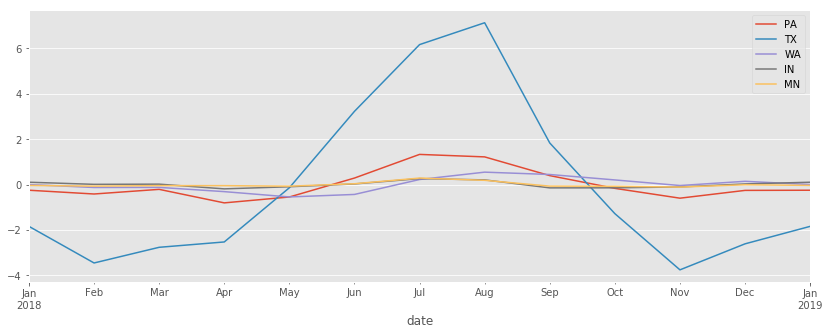

In [192]:
yearPA.plot(label='PA')
yearTX.plot(label='TX')
yearWA.plot(label='WA')
yearIN.plot(label='IN')
yearMN.plot(label='MN')

plt.legend();